In [80]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix,roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder,LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import export_graphviz
import graphviz

pd.options.display.max_rows = 60
pd.options.display.max_columns = 20



id_student  num_of_prev_attempts final_result  weighted_grade  \
0     29764       0                     Pass         89.65            
1     29820       0                     Pass         84.58            
2     40604       0                     Pass         51.44            
3     42638       0                     Pass         75.13            
4     46605       0                     Pass         93.22            
...     ...      ..                      ...           ...            
4946  2677210     0                     Pass         87.30            
4947  2678380     0                     Pass         81.80            
4948  2684043     0                     Pass         80.05            
4949  2685863     0                     Pass         65.75            
4950  2689863     1                     Pass         71.05            

      pass_rate  exam_score        date  sum_click  
0     1.000      94.0        103.457907  2.706754   
1     1.000      76.0        87.617265   1.539047   
2     0.625      66.0        49.181286   1.562619   
3     1.000      50.0        118.698642  2.189217   
4     1.000      98.0        75.791987   2.100617   
...     ...       ...              ...        ...   
4946  1.000      71.0        122.839227  1.322085   
4947  1.000      64.0        63.128534   1.564681   
4948  1.000      69.0        92.756349   1.615318   
4949  1.000      49.0        128.453230  1.975989   
4950  1.000      67.0        77.007493   1.631076   

[4951 rows x 8 columns]

# Data preprocessing

In [ ]:
studInfo=pd.read_csv("studentInfo.csv")
assessments=pd.read_csv("assessments.csv")
studAss=pd.read_csv("studentAssessment.csv")
studVle=pd.read_csv("studentVle.csv")
vle=pd.read_csv("vle.csv")

# 데이터셋 분리
# 기말고사 데이터 분리
exams=assessments[assessments["assessment_type"]=="Exam"]
others=assessments[assessments["assessment_type"]!="Exam"]

# ==========Data value changing==========
# 가중치가 0인 TMA CMA들 각각 평균 가중치로 채움

#print(others[others["weight"]==0])
tma=others[others["assessment_type"]=="TMA"]
cma=others[others["assessment_type"]=="CMA"]
others.loc[(others['assessment_type'] == "TMA")&(others['weight']==0), 'weight'] = tma["weight"].mean()
others.loc[(others['assessment_type'] == "CMA")&(others['weight']==0), 'weight'] = cma["weight"].mean()
#print(others[others["weight"]==0])

# ==========Feature Engineering==========

# 기말고사를 제외하고 수업당 평가 개수
amounts=others.groupby(["code_module","code_presentation"]).count()["id_assessment"] 
amounts=amounts.reset_index()
#print(amounts.head())

# 기존 studentAss테이블과 기말고사제외한 평가들 테이블 머지
stud_ass=pd.merge(studAss,others,how="inner",on=["id_assessment"])

# 평가가 합격인지 불합격인지 함수
def pass_fail(grade):
    if grade>=40:
        return True
    else:
        return False

# pass 피쳐 생성(T/F) 
stud_ass["pass"]=stud_ass["score"].apply(pass_fail)
#print(stud_ass.head())
# 평가당 점수 가중치 피쳐생성
stud_ass["weighted_grade"]=stud_ass["score"]*stud_ass["weight"]/100
#print(stud_ass.head())

# 각 평가당 점수가중치를 모두 더해서 그 학생의 수업에서의 총 점수가중치피쳐 생성
avg_grade=stud_ass.groupby(["id_student","code_module","code_presentation"]).sum()["weighted_grade"].reset_index()
#25839개
#print(avg_grade.head())

# pss 피쳐를 이용하여 그 학생의 그 수업에서 평가 pass확률 피쳐 생성
pass_rate=pd.merge((stud_ass[stud_ass["pass"]==True].groupby(["id_student","code_module","code_presentation"]).count()["pass"]).reset_index(),amounts,how="left",on=["code_module","code_presentation"])
pass_rate["pass_rate"]=pass_rate["pass"]/pass_rate["id_assessment"]
pass_rate.drop(["pass","id_assessment"], axis=1,inplace=True)
#25239개
#print(pass_rate.head())

# 학생의 기말고사 성적 피쳐
stud_exams=pd.merge(studAss,exams,how="inner",on=["id_assessment"])
stud_exams["exam_score"]=stud_exams["score"]
stud_exams.drop(["id_assessment","date_submitted","is_banked", "score","assessment_type","date","weight"],axis=1,inplace=True)
#4959개
#print(stud_exams.head())

# Data restructing
# 평가 정보 테이블에 점수 가중치와 평가통과확률 기말고사 시험점수 피쳐들 추가
df_1=pd.merge(avg_grade,pass_rate,how="inner",on=["id_student","code_module","code_presentation"])
assessment_info=pd.merge(df_1, stud_exams, how="inner", on=["id_student","code_module","code_presentation"])
#print(assessment_info.head())

# 학생이 자료의 종류당 상호작용한 횟수와 시간
avg_per_site=studVle.groupby(["id_student","id_site","code_module","code_presentation"]).mean()[["date","sum_click"]].reset_index()
#print(avg_per_site.head())
# 학생이 수업에서 자료들과 상호작용한 횟수와 시간의 평균값
click_per_student=avg_per_site.groupby(["id_student","code_module","code_presentation"]).mean()[["date","sum_click"]].reset_index()
#print(click_per_student.head())

# Data value changing
# 학생이 수업을 드랍한 경우->Fail 장학생으로 패스한 경우-> Pass
#32593개
#print(studInfo)
studInfo.loc[(studInfo['final_result'] == "Withdrawn"), 'final_result'] = "Fail"
studInfo.loc[(studInfo['final_result'] == "Distinction"), 'final_result'] = "Pass"

# 나머지 필요없는 피쳐들은 드랍
studInfo=studInfo[["code_module","code_presentation","id_student","num_of_prev_attempts","final_result"]]

# 학생 정보테이블과 머지하여 최종 데이터셋 생성
# 총 4950개 로우
df_2=pd.merge(studInfo,assessment_info,how="inner",on=["id_student","code_module","code_presentation"])
df=pd.merge(df_2,click_per_student,how="inner", on=["id_student","code_module","code_presentation"])

df.drop(["code_module","code_presentation"],axis=1,inplace=True)
#print(final_df)

df


## Drop outliers

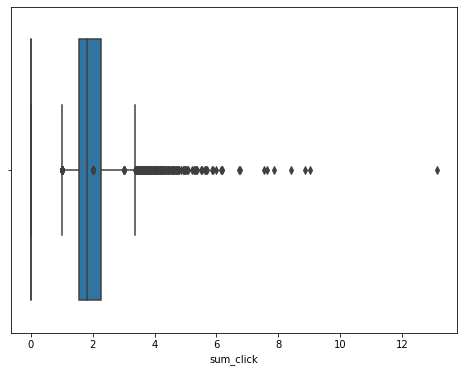

In [81]:
# 아웃라이어 2명을 발견함
# 평균 클릭수가 혼자 너무 많음
# 수업을 재시도 한 횟수가 혼자 너무 많음

#sns.pairplot(final_df["num_of_prev_attempts","sum_click"])
plt.figure(figsize=(8,6))
sns.boxplot(x = df['num_of_prev_attempts'])
sns.boxplot(x = df['sum_click'])
plt.show()



In [83]:
# 아웃라이어 제거
df=df[df["sum_click"]<=6]
df=df[df["num_of_prev_attempts"]<=2]


## Encoding 'final_result'

In [84]:

final_result_encode={
'Pass':1,
'Fail':0}
df['final_result']=df.final_result.map(final_result_encode)
print(df['final_result'].value_counts())
df

1    4261
0    665 
Name: final_result, dtype: int64


id_student  num_of_prev_attempts  final_result  weighted_grade  \
0     29764       0                     1             89.65            
1     29820       0                     1             84.58            
2     40604       0                     1             51.44            
3     42638       0                     1             75.13            
4     46605       0                     1             93.22            
...     ...      ..                    ..               ...            
4946  2677210     0                     1             87.30            
4947  2678380     0                     1             81.80            
4948  2684043     0                     1             80.05            
4949  2685863     0                     1             65.75            
4950  2689863     1                     1             71.05            

      pass_rate  exam_score        date  sum_click  
0     1.000      94.0        103.457907  2.706754   
1     1.000      76.0        87.617265   1.539047   
2     0.625      66.0        49.181286   1.562619   
3     1.000      50.0        118.698642  2.189217   
4     1.000      98.0        75.791987   2.100617   
...     ...       ...              ...        ...   
4946  1.000      71.0        122.839227  1.322085   
4947  1.000      64.0        63.128534   1.564681   
4948  1.000      69.0        92.756349   1.615318   
4949  1.000      49.0        128.453230  1.975989   
4950  1.000      67.0        77.007493   1.631076   

[4926 rows x 8 columns]

In [85]:
temp_df=df.drop(["id_student"],axis=1,inplace=False)
temp_df

num_of_prev_attempts  final_result  weighted_grade  pass_rate  \
0     0                     1             89.65           1.000       
1     0                     1             84.58           1.000       
2     0                     1             51.44           0.625       
3     0                     1             75.13           1.000       
4     0                     1             93.22           1.000       
...  ..                    ..               ...             ...       
4946  0                     1             87.30           1.000       
4947  0                     1             81.80           1.000       
4948  0                     1             80.05           1.000       
4949  0                     1             65.75           1.000       
4950  1                     1             71.05           1.000       

      exam_score        date  sum_click  
0     94.0        103.457907  2.706754   
1     76.0        87.617265   1.539047   
2     66.0        49.181286   1.562619   
3     50.0        118.698642  2.189217   
4     98.0        75.791987   2.100617   
...    ...              ...        ...   
4946  71.0        122.839227  1.322085   
4947  64.0        63.128534   1.564681   
4948  69.0        92.756349   1.615318   
4949  49.0        128.453230  1.975989   
4950  67.0        77.007493   1.631076   

[4926 rows x 7 columns]

## Feature selection - Correlation heat map

<AxesSubplot:>

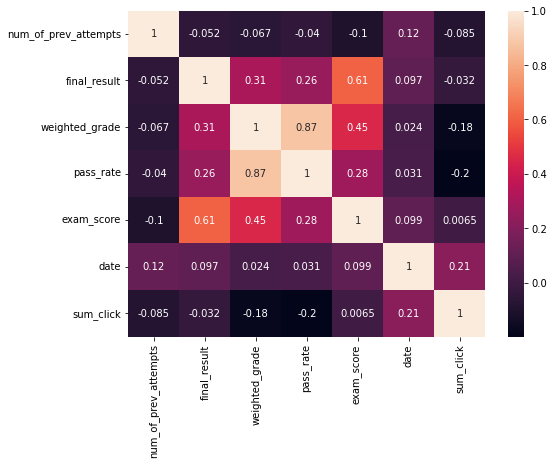

In [86]:
plt.figure(figsize=(8,6))
sns.heatmap(temp_df.corr(),annot=True)



## Feature selection - SelectKBest

In [87]:
# X,y setting
X=temp_df.drop("final_result", axis=1)
y=temp_df["final_result"]

In [88]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

    
kbest=SelectKBest(score_func=f_regression,k=6)
result=kbest.fit(X,y)
dfcolumns=pd.DataFrame(X.columns)
dfscores=pd.DataFrame(result.scores_)
    
featureScores=pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns=['Feature','Score']
    
featureScores.nlargest(6,'Score')
    

Feature        Score
3  exam_score            2845.566125
1  weighted_grade        527.986033 
2  pass_rate             349.848021 
4  date                  46.434157  
0  num_of_prev_attempts  13.240927  
5  sum_click             5.174850

## Feature selection - feature_importances_

[0.01453724 0.14739004 0.07520378 0.57737029 0.09346577 0.09203287]


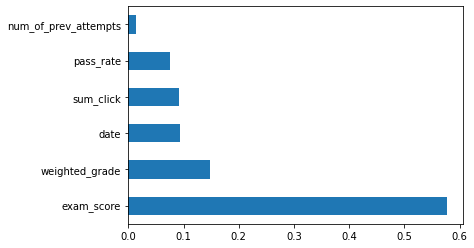

In [89]:
from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use built-in class feature_importances of tree-based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, 
index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

## select top 3 feature "exam_score","weighted_grade","pass_rate"

In [90]:
final_df=df[['final_result','exam_score','pass_rate','weighted_grade']]
final_df

final_result  exam_score  pass_rate  weighted_grade
0     1             94.0        1.000      89.65         
1     1             76.0        1.000      84.58         
2     1             66.0        0.625      51.44         
3     1             50.0        1.000      75.13         
4     1             98.0        1.000      93.22         
...  ..              ...          ...        ...         
4946  1             71.0        1.000      87.30         
4947  1             64.0        1.000      81.80         
4948  1             69.0        1.000      80.05         
4949  1             49.0        1.000      65.75         
4950  1             67.0        1.000      71.05         

[4926 rows x 4 columns]

In [91]:
print("==========Final DataFrame==========")
print(final_df)
print(final_df.columns)


==========Final DataFrame==========
      final_result  exam_score  pass_rate  weighted_grade
0     1             94.0        1.000      89.65         
1     1             76.0        1.000      84.58         
2     1             66.0        0.625      51.44         
3     1             50.0        1.000      75.13         
4     1             98.0        1.000      93.22         
...  ..              ...          ...        ...         
4946  1             71.0        1.000      87.30         
4947  1             64.0        1.000      81.80         
4948  1             69.0        1.000      80.05         
4949  1             49.0        1.000      65.75         
4950  1             67.0        1.000      71.05         

[4926 rows x 4 columns]
Index(['final_result', 'exam_score', 'pass_rate', 'weighted_grade'], dtype='object')


In [92]:
print(final_df['final_result'].value_counts())

1    4261
0    665 
Name: final_result, dtype: int64


In [93]:
# X,y setting
X=final_df.drop("final_result", axis=1)
y=final_df["final_result"]

# Classification

## - Decision Tree

In [94]:
for i in range(2,8):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=i/10,stratify=y)
    # Decision tree classifier
    for j in range(2,10):

        dt=DecisionTreeClassifier(max_depth=j,criterion="entropy",min_samples_split=2)
        dt=dt.fit(X_train,y_train)
        predict_dt=dt.predict(X_test)
        print("Test size = {} max_depth = {}".format(i/10,j))
        print("Testset accuracy: {:.3f}\n".format(dt.score(X_test, y_test)))


Test size = 0.2 max_depth = 2
Testset accuracy: 0.948

Test size = 0.2 max_depth = 3
Testset accuracy: 0.948

Test size = 0.2 max_depth = 4
Testset accuracy: 0.946

Test size = 0.2 max_depth = 5
Testset accuracy: 0.946

Test size = 0.2 max_depth = 6
Testset accuracy: 0.945

Test size = 0.2 max_depth = 7
Testset accuracy: 0.948

Test size = 0.2 max_depth = 8
Testset accuracy: 0.946

Test size = 0.2 max_depth = 9
Testset accuracy: 0.942

Test size = 0.3 max_depth = 2
Testset accuracy: 0.951

Test size = 0.3 max_depth = 3
Testset accuracy: 0.948

Test size = 0.3 max_depth = 4
Testset accuracy: 0.947

Test size = 0.3 max_depth = 5
Testset accuracy: 0.947

Test size = 0.3 max_depth = 6
Testset accuracy: 0.948

Test size = 0.3 max_depth = 7
Testset accuracy: 0.945

Test size = 0.3 max_depth = 8
Testset accuracy: 0.949

Test size = 0.3 max_depth = 9
Testset accuracy: 0.940

Test size = 0.4 max_depth = 2
Testset accuracy: 0.952

Test size = 0.4 max_depth = 3
Testset accuracy: 0.952

Test size 

### Function that implement Gridsearch decisionTree parameters with different K-folds cross validation, returns dataframe of best parameter and best score of each K-fold.

In [95]:
def decision_tree_GridsearchCV(X,y):
    
    result_df=pd.DataFrame(index=range(0,6),columns=['K-Fold','Best parameter','Best score'])

    # GridSearchCV의 param_grid 설정
    params = {
        'max_depth': range(2,11),
        'min_samples_split': (2,11),
        'criterion':['entropy','gini']
        }

    dt = DecisionTreeClassifier()
    # Gridsearch with different K-Fold cross validation, k= (5 to10)
    for i in range(5,11):    
        tree_gscv = GridSearchCV(dt, param_grid=params, cv=i, refit=True)
        tree_gscv.fit(X, y)
        result_df.iloc[i-5,:]=[i,tree_gscv.best_params_,tree_gscv.best_score_]
    return result_df    




In [96]:
pd.set_option('display.max_colwidth', -1)
decision_tree_GridsearchCV(X,y)

K-Fold                                                    Best parameter  \
0  5      {'criterion': 'entropy', 'max_depth': 2, 'min_samples_split': 2}   
1  6      {'criterion': 'entropy', 'max_depth': 2, 'min_samples_split': 2}   
2  7      {'criterion': 'entropy', 'max_depth': 2, 'min_samples_split': 2}   
3  8      {'criterion': 'entropy', 'max_depth': 2, 'min_samples_split': 2}   
4  9      {'criterion': 'entropy', 'max_depth': 2, 'min_samples_split': 2}   
5  10     {'criterion': 'entropy', 'max_depth': 2, 'min_samples_split': 2}   

  Best score  
0  0.95127    
1  0.951279   
2  0.951271   
3  0.951271   
4  0.951252   
5  0.951262

### Analysis of decision tree
### 6-fold , parameter {'criterion': 'entropy', 'max_depth': 2, 'min_samples_split': 2} showed best score 0.951279

## Evaluate best model with confusion matrix

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,stratify=y)

In [129]:
# best model evaluation
bestclassifier=DecisionTreeClassifier(max_depth=2,criterion="entropy",min_samples_split=2)
bestTree=bestclassifier.fit(X_train,y_train)



In [135]:
# visualize decision tree
from sklearn import tree
from sklearn.tree import export_graphviz
import graphviz
import pydotplus
from IPython.display import Image


text_representation = tree.export_text(bestclassifier)
print(text_representation)


fig = plt.figure(figsize=(25,20))

dot_data2 = tree.export_graphviz(bestclassifier,        # 의사결정나무 모형 대입
                               out_file = None,     # file로 변환할 것인가
                               feature_names = ['weighted_grade','pass_rate','exam_score'], # feature 이름
                               class_names = ['Pass', 'Fail'],   # target 이름
                               filled = True,        # 그림에 색상을 넣을것인가
                               rounded = True,       # 반올림을 진행할 것인가
                               special_characters = True)    # 특수문자를 사용하나

(graph,)=pydotplus.graph_from_dot_file('decisionTree.dot',encoding='utf8')
graph.write_png('decisionTree.dot')
#graph = pydotplus.graph_from_dot_data(dot_data2)   
#Image(graph.create_png())

result_tree1=tree1.predict(X_test)


ModuleNotFoundError: No module named 'pydotplus'

In [ ]:
predict_bestTree=bestTree.predict(X_test)

# Show confusion matrix
confusion_matrix(y_test,predict_bestTree)

In [99]:
# Show classification report
print(classification_report(y_test,predict_bestTree))


              precision    recall  f1-score   support

           0       0.88      0.77      0.82       200
           1       0.96      0.98      0.97      1278

    accuracy                           0.95      1478
   macro avg       0.92      0.87      0.90      1478
weighted avg       0.95      0.95      0.95      1478



<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

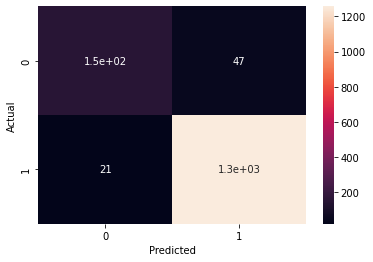

In [100]:

# show confusion matrix with heapmap
confusion_matrix = pd.crosstab(y_test,
predict_bestTree, rownames=['Actual'], 
colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)

### Analysis of DecisionTree : 
### Precision:0.96  Recall: 0.99  F1 score:0.97

## Classification - KNN

### Function that implement Scaling and Gridsearch KNN parameters with different K-folds cross validation, which returns dataframe of best parameter and best score of each K-fold.

In [101]:
from sklearn.neighbors import KNeighborsClassifier


def Scale_Knn_gridsearch(scaler,X,y):
    
    result_df=pd.DataFrame(index=range(0,6),columns=['K-Fold','Best parameter','Best score'])
    
    X=pd.DataFrame(scaler.fit_transform(X),columns=[X.columns])
   
    # KNN gridsearch parameter setting
    param_grid={'n_neighbors':np.arange(1,21)}
    
    knn=KNeighborsClassifier()
    
    # Gridsearch with different K-Fold cross validation, k= (5 to10)
    for i in range(5,11):
        knn_gscv=GridSearchCV(knn,param_grid,cv=i)
        knn_gscv.fit(X,y)
        result_df.iloc[i-5,:]=[i,knn_gscv.best_params_,knn_gscv.best_score_]
    
    return (result_df)


In [102]:
Scale_Knn_gridsearch(MinMaxScaler(),X,y)


K-Fold       Best parameter Best score
0  5      {'n_neighbors': 16}  0.947618 
1  6      {'n_neighbors': 18}  0.947219 
2  7      {'n_neighbors': 16}  0.947418 
3  8      {'n_neighbors': 20}  0.946609 
4  9      {'n_neighbors': 15}  0.947403 
5  10     {'n_neighbors': 18}  0.946807

In [103]:
Scale_Knn_gridsearch(StandardScaler(),X,y)


K-Fold       Best parameter Best score
0  5      {'n_neighbors': 16}  0.947618 
1  6      {'n_neighbors': 18}  0.947016 
2  7      {'n_neighbors': 16}  0.947621 
3  8      {'n_neighbors': 20}  0.946609 
4  9      {'n_neighbors': 15}  0.947809 
5  10     {'n_neighbors': 20}  0.947415

In [104]:
Scale_Knn_gridsearch(RobustScaler(),X,y)

K-Fold       Best parameter Best score
0  5      {'n_neighbors': 16}  0.947619 
1  6      {'n_neighbors': 20}  0.946001 
2  7      {'n_neighbors': 16}  0.947621 
3  8      {'n_neighbors': 16}  0.946    
4  9      {'n_neighbors': 18}  0.947809 
5  10     {'n_neighbors': 16}  0.947619

### Analysis of KNN:
### StandardScaler+ 9-Folds + 'n_neighbors': 15 →  showed best score 0.947809

# Classification Ensemble learning

### RandomForest Classifier

In [105]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, max_depth=6)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)
y_train = y_train.values.ravel()
model.fit(X_train, y_train)
model.predict(X_test)
print('Accuracy:',model.score(X_test, y_test))

Accuracy: 0.9503042596348884


### AdaBoost Classifier

In [106]:
from sklearn.ensemble import AdaBoostClassifier
model = AdaBoostClassifier(n_estimators=100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

model.fit(X_train, y_train)
model.predict(X_test)
print('Accuracy:',model.score(X_test, y_test))



Accuracy: 0.9482758620689655


### Analysis of ensemble learning :
### Showed higher accuracy than KNN classifier and little higher than DecisionTree.

## Overall analysis: 
### DecisionTree best score 0.951279
### KNN best score 0.947809
### Ensemble learning- RandomForest 0.9503042, AdaBoost 0.94827586

# Clustering

In [107]:
df_features_cluster=df.copy()
df_features_cluster=df.drop("id_student", axis=1)

colname=df_features_cluster.columns.values
colname

array(['num_of_prev_attempts', 'final_result', 'weighted_grade',
       'pass_rate', 'exam_score', 'date', 'sum_click'], dtype=object)

### Scaling

In [108]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

mmDf=pd.DataFrame(MinMaxScaler().fit_transform(df_features_cluster),columns=[colname])
ssDf=pd.DataFrame(StandardScaler().fit_transform(df_features_cluster),columns=[colname])
rbDf=pd.DataFrame(RobustScaler().fit_transform(df_features_cluster),columns=[colname])

## 전체 dataset에서 2개의 feature만 선택하여 clustering 후 시각화

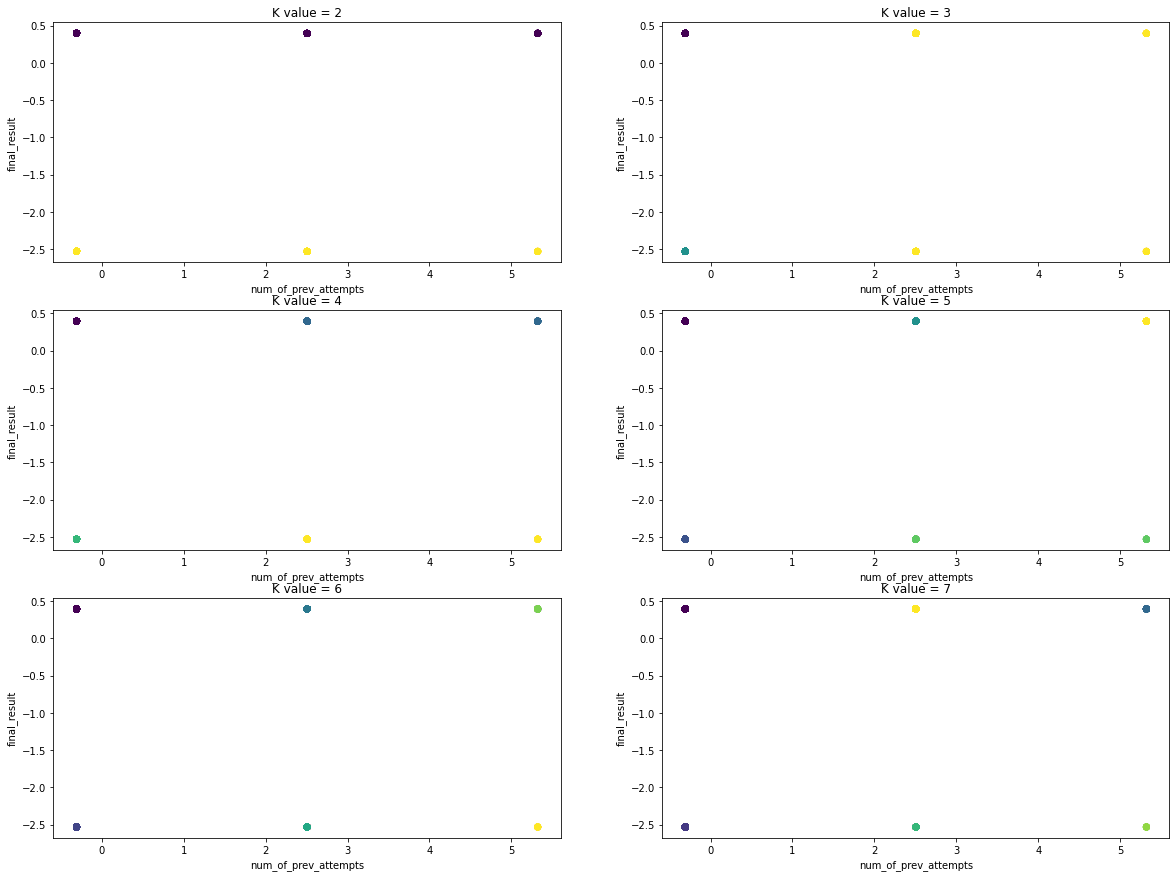

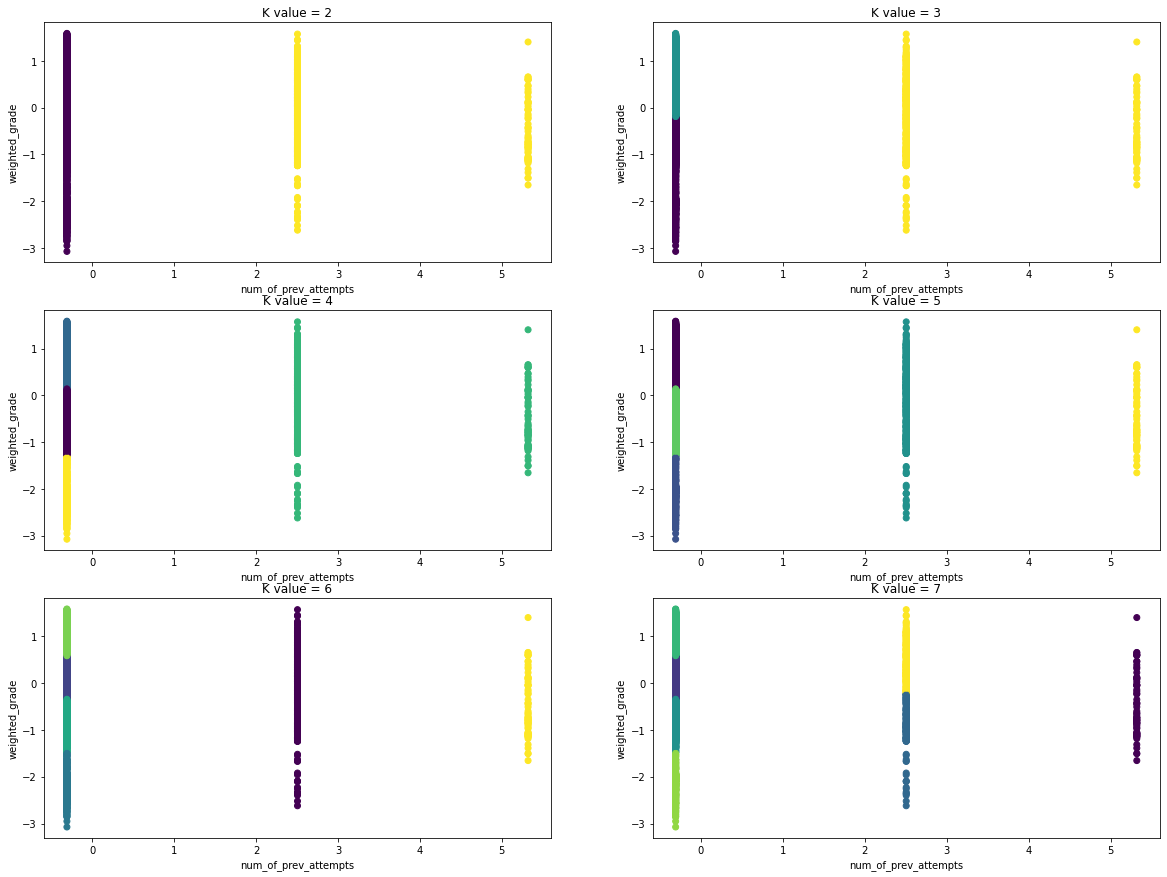

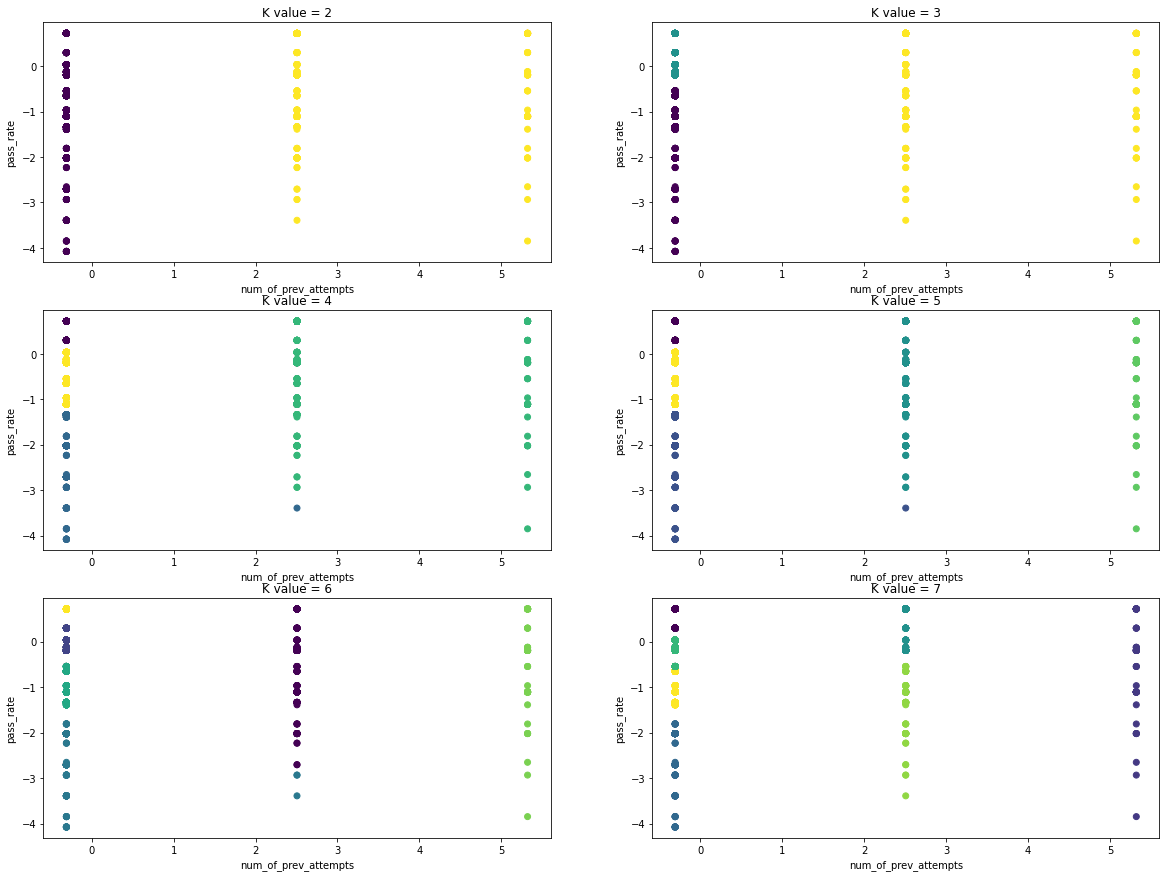

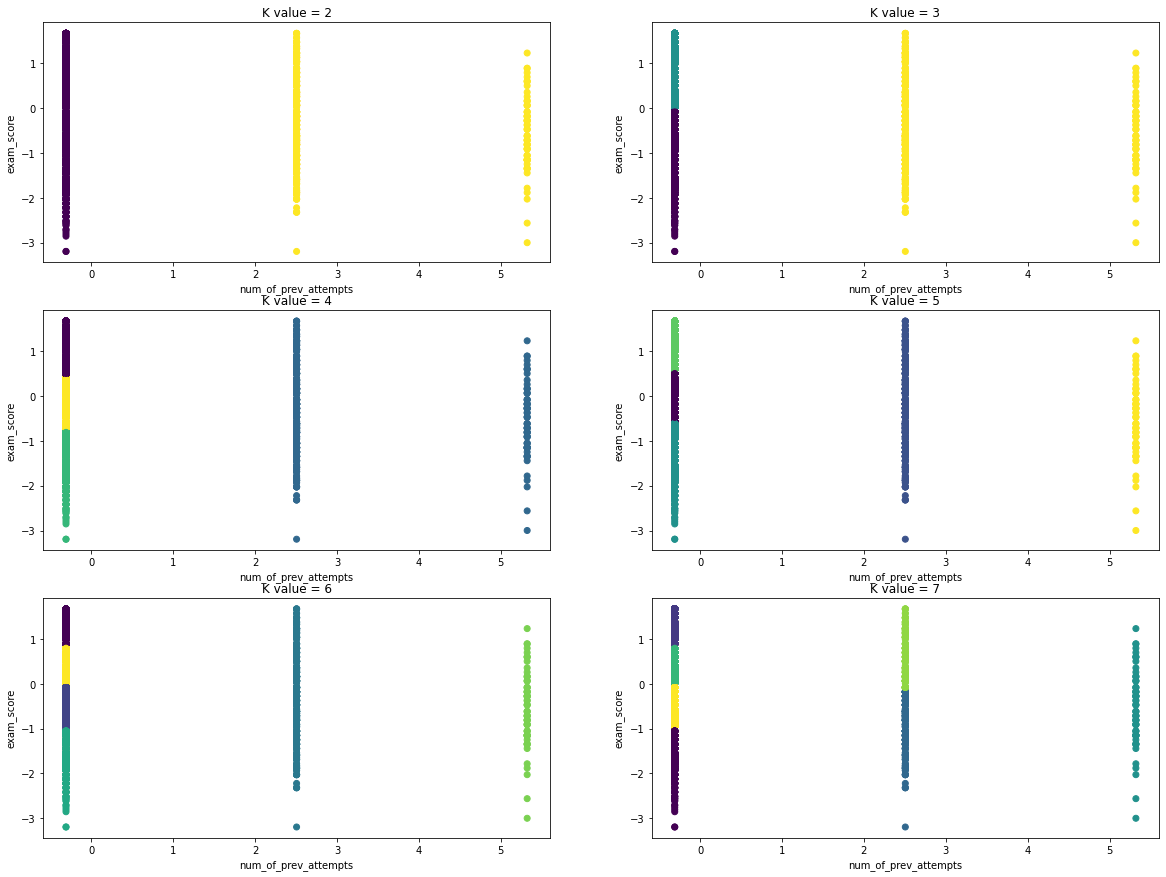

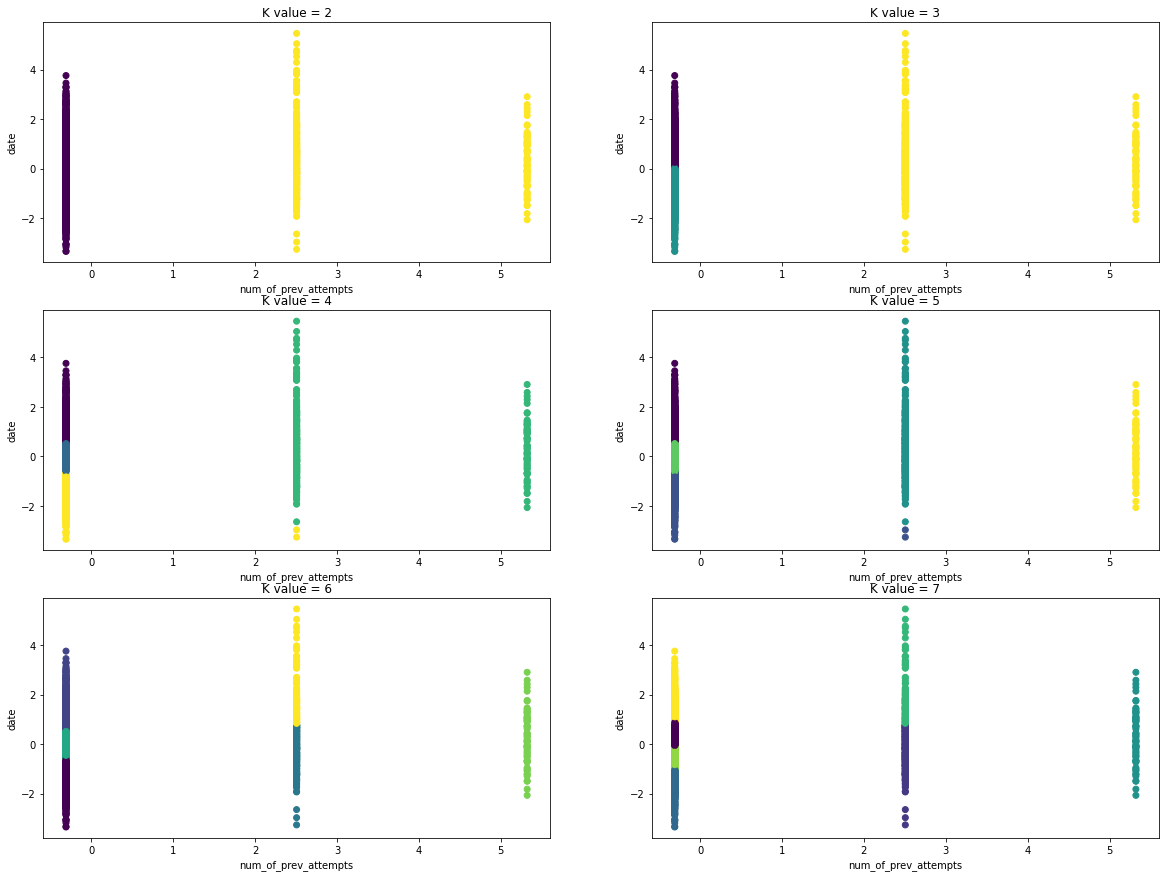

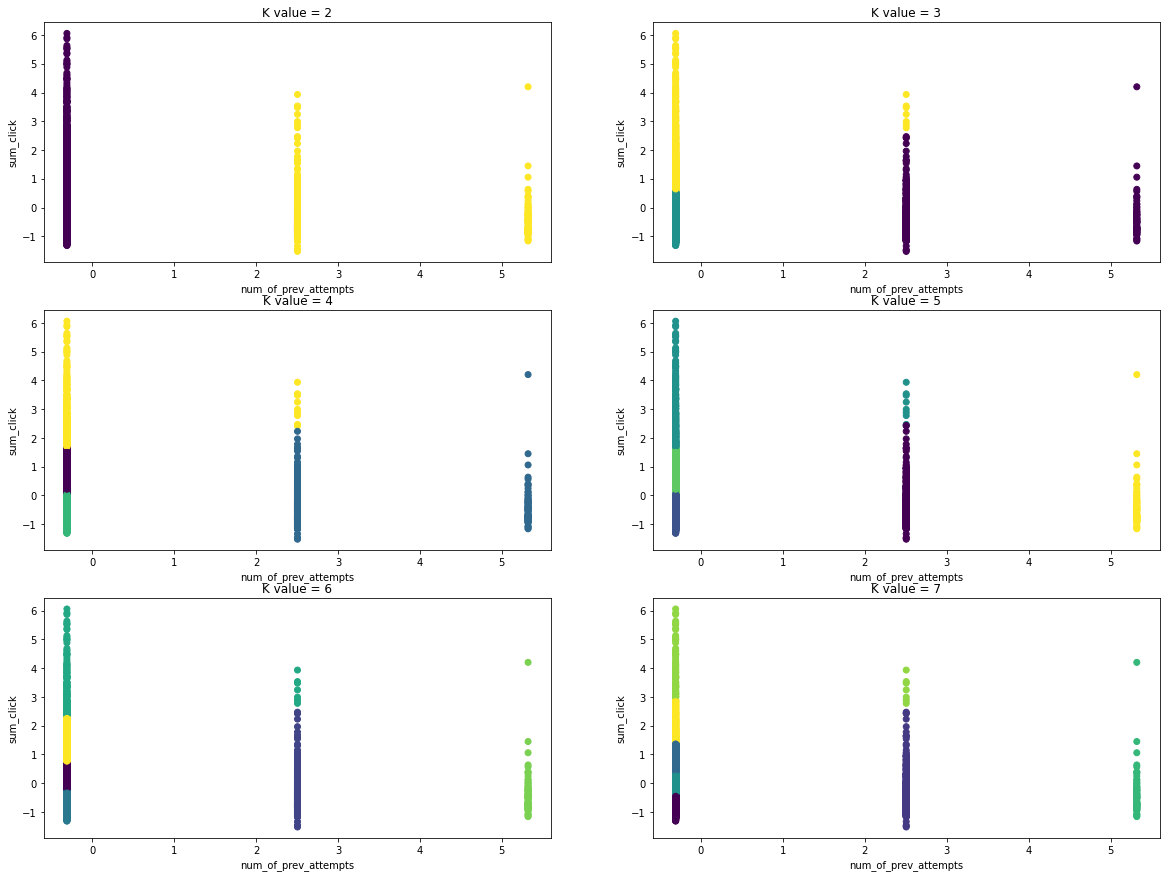

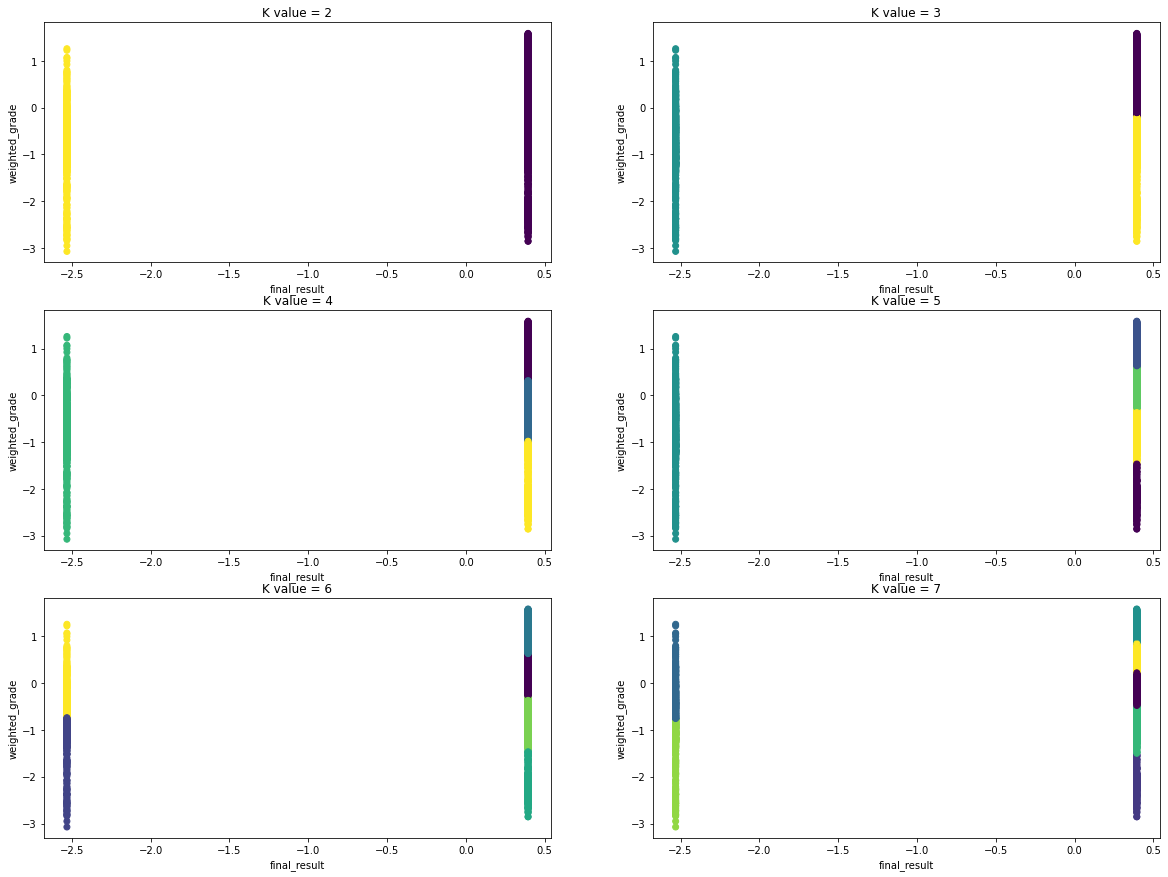

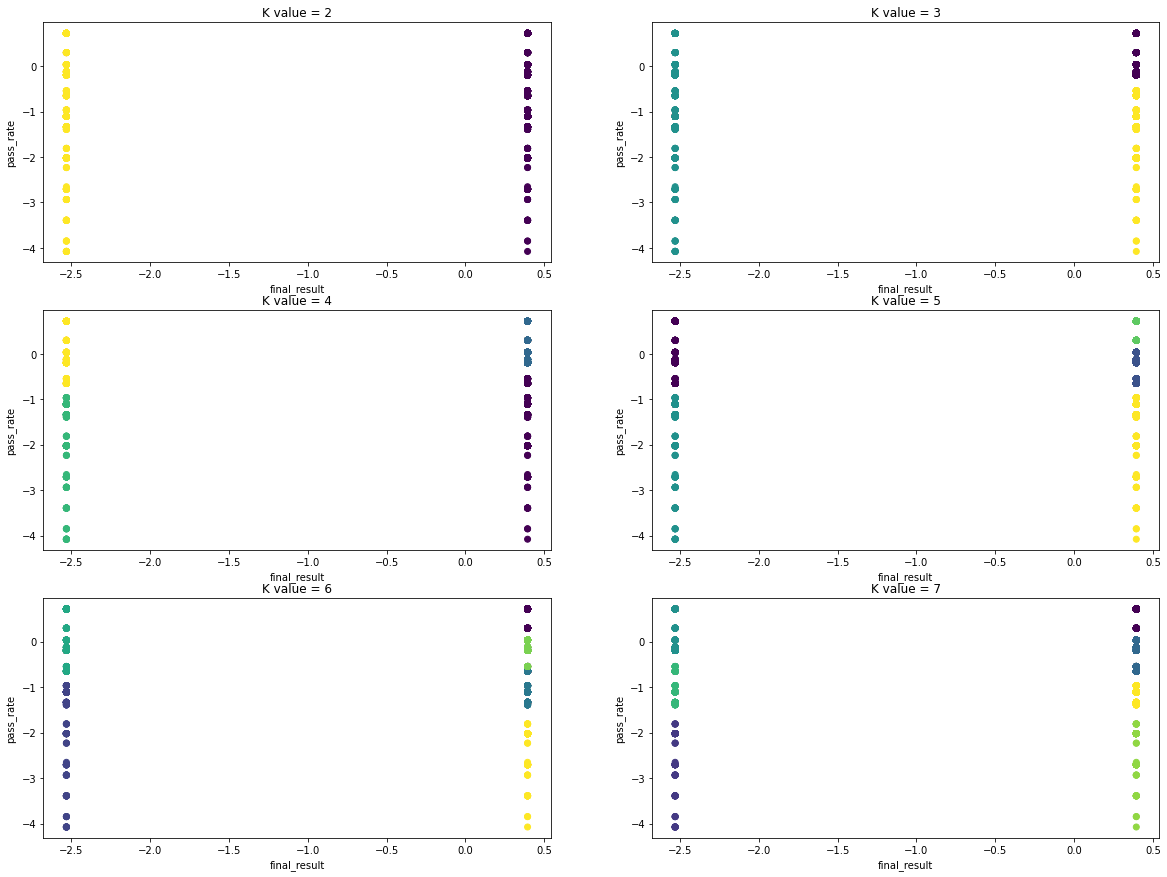

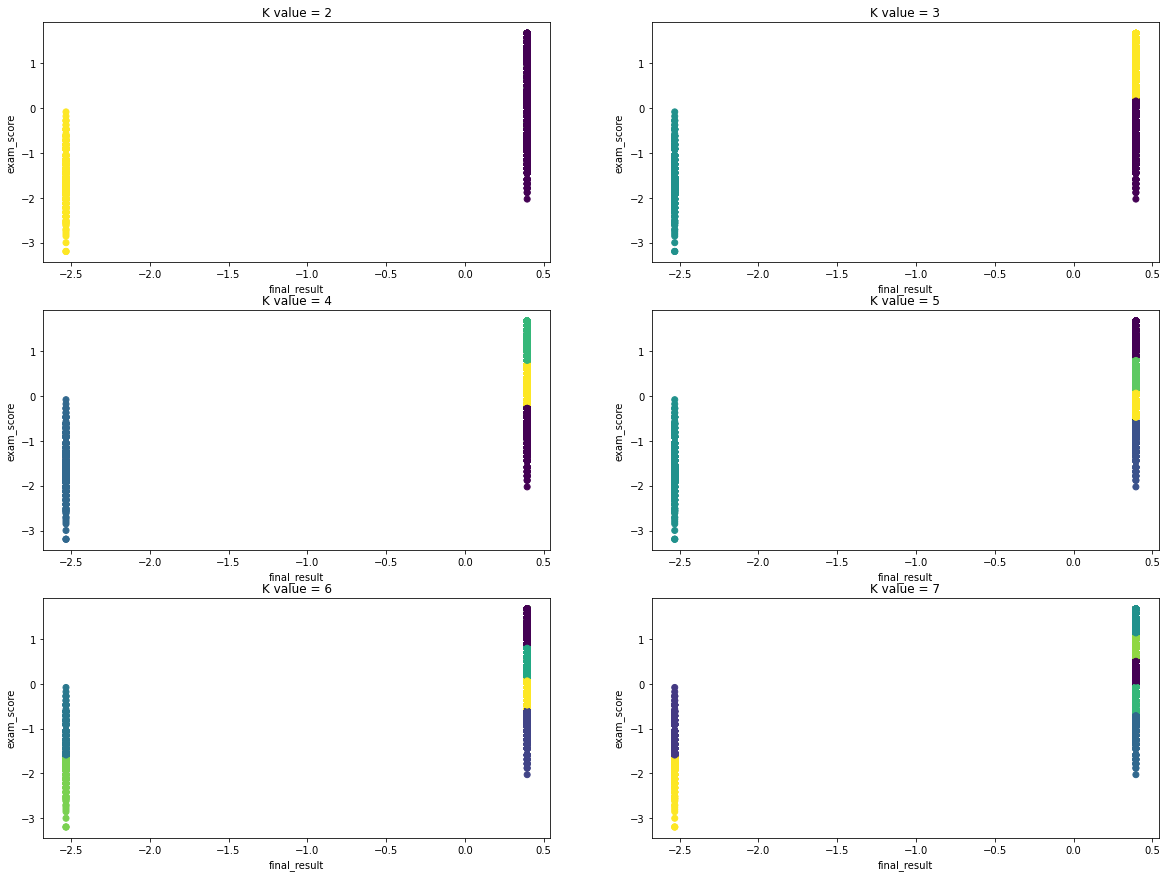

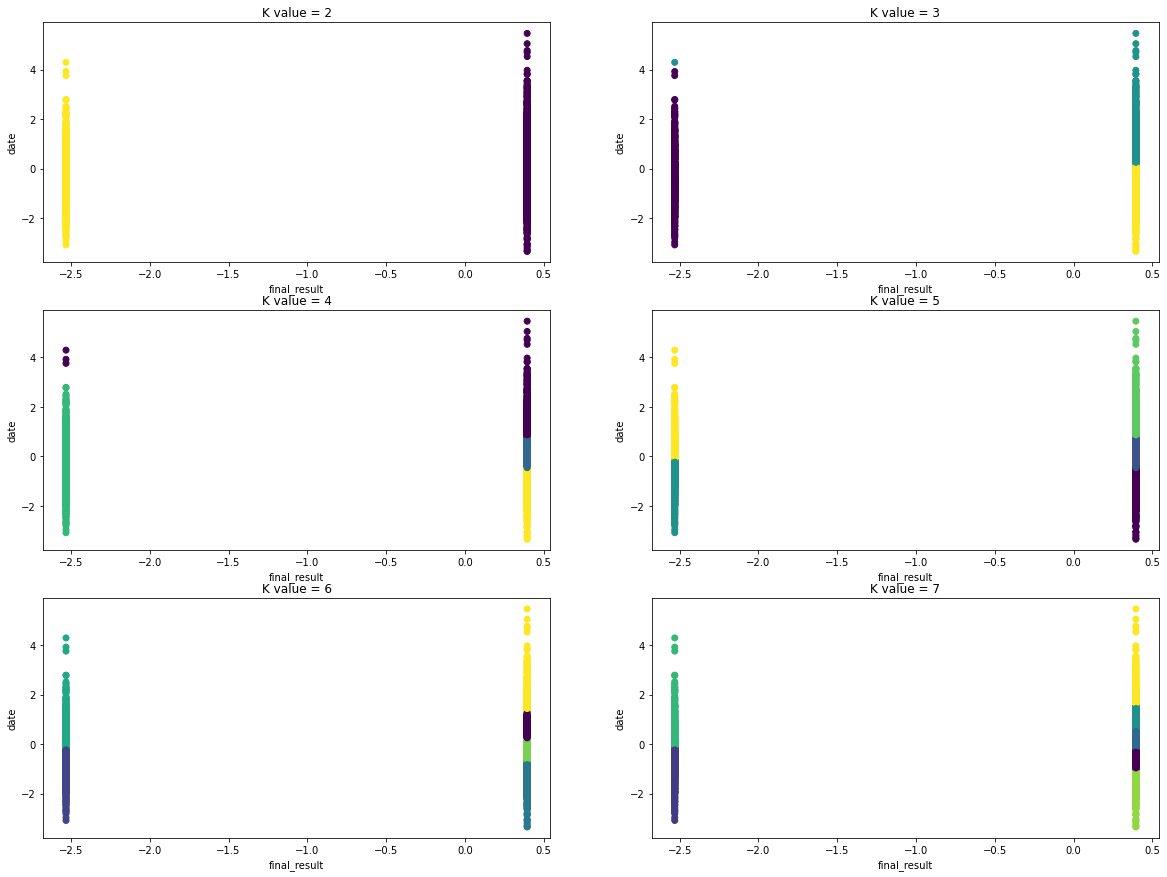

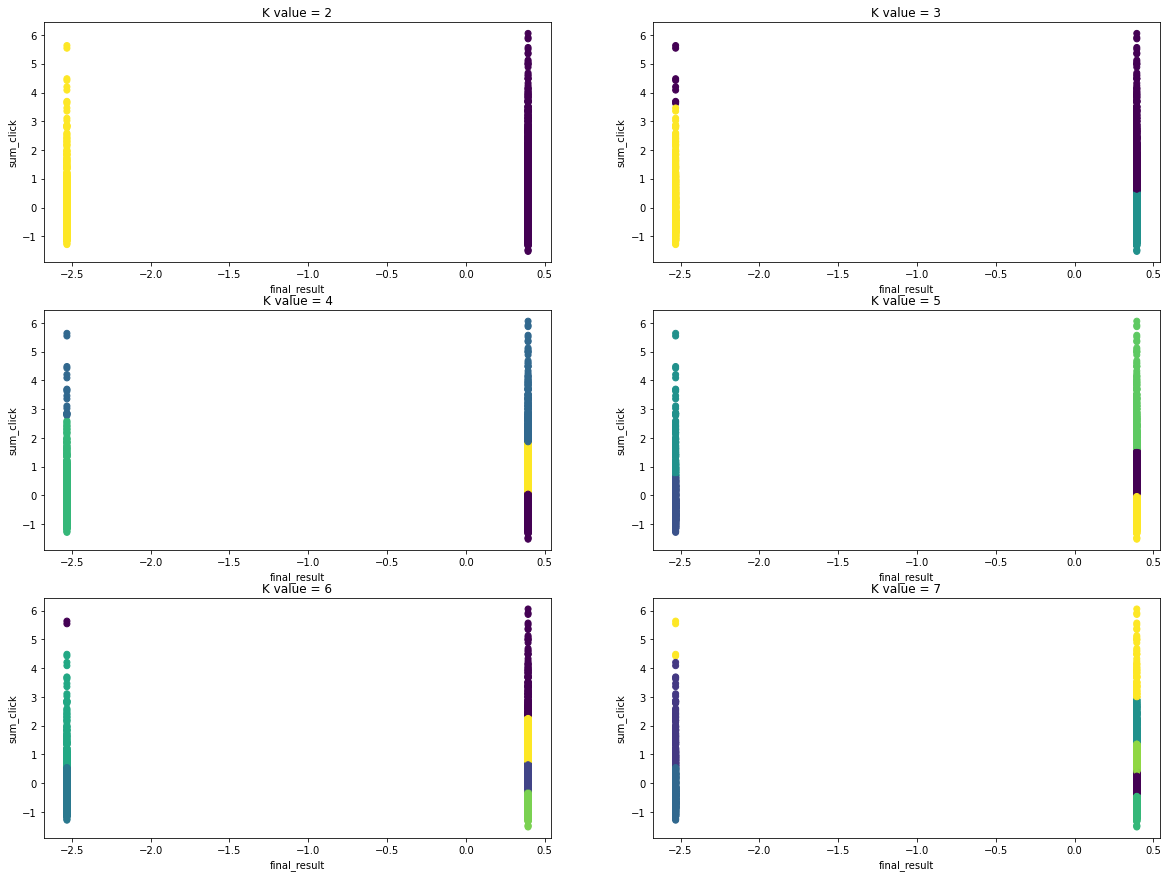

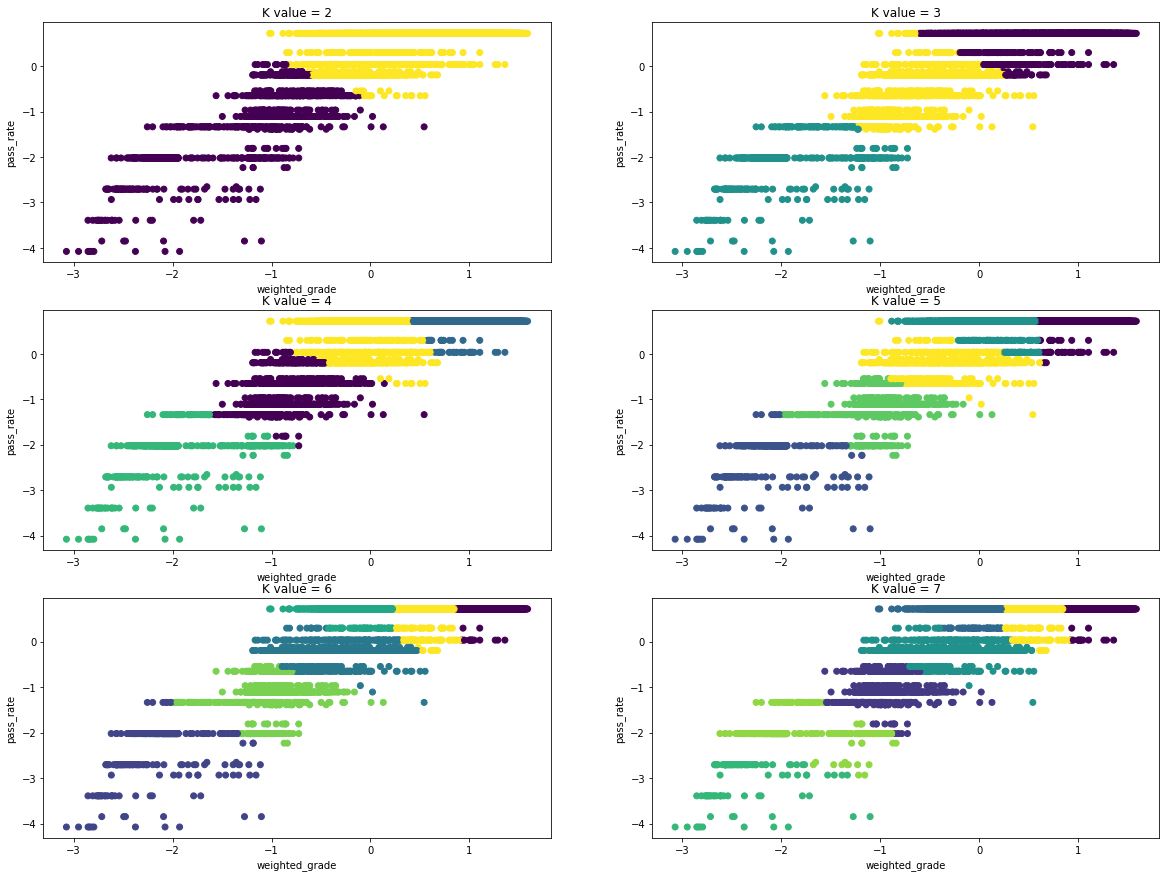

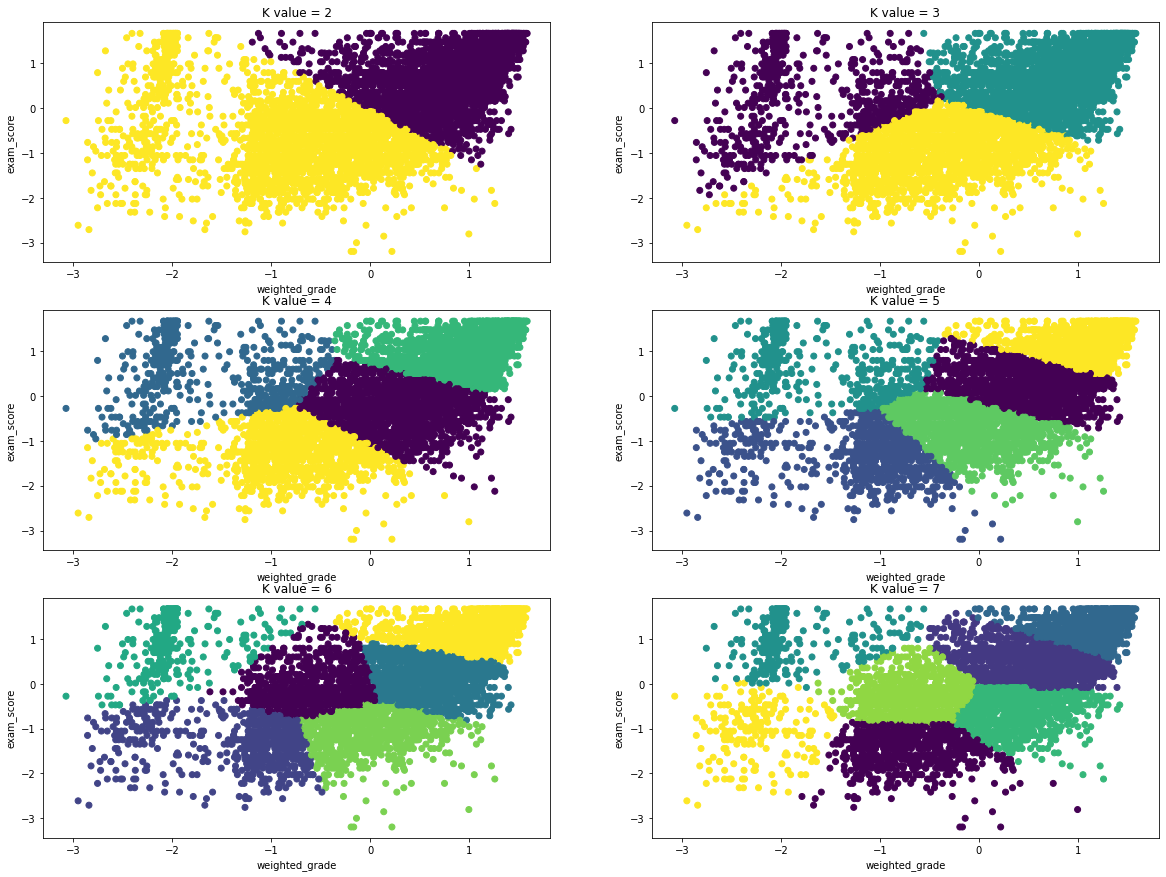

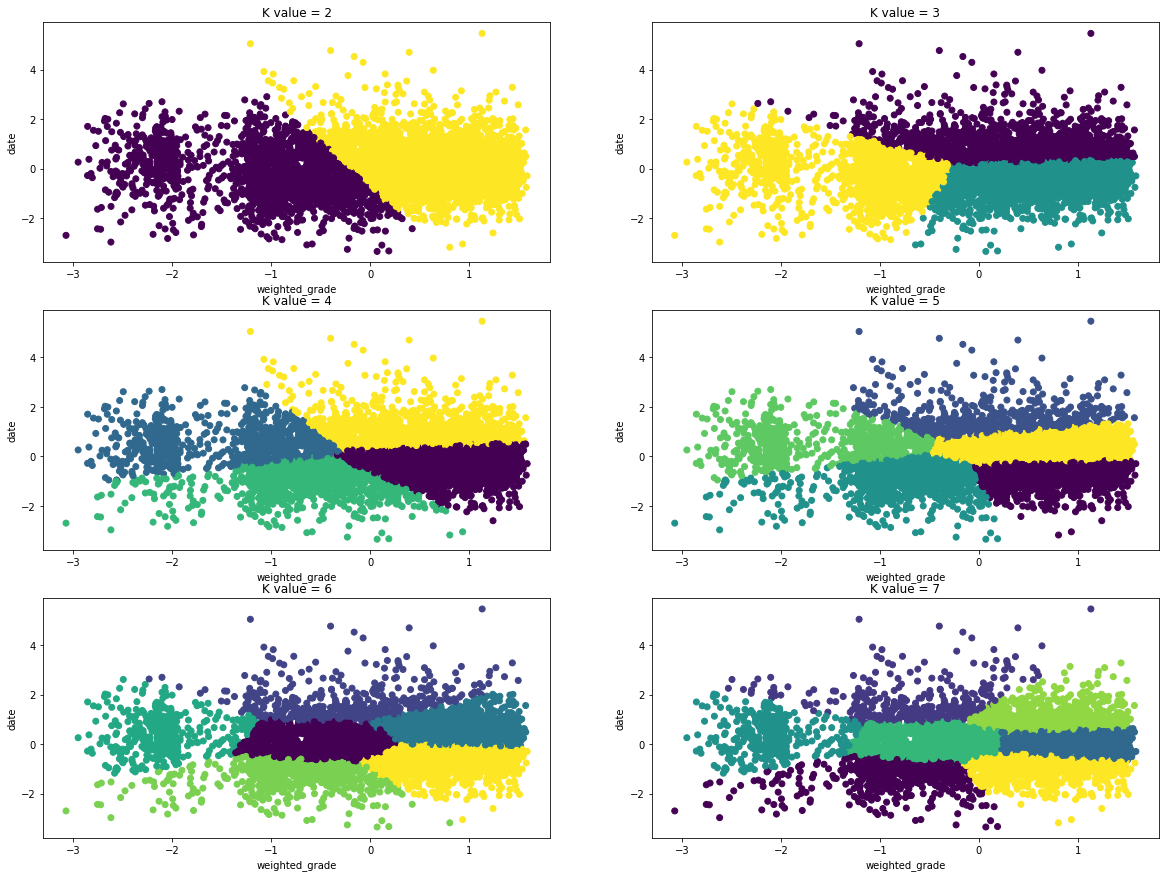

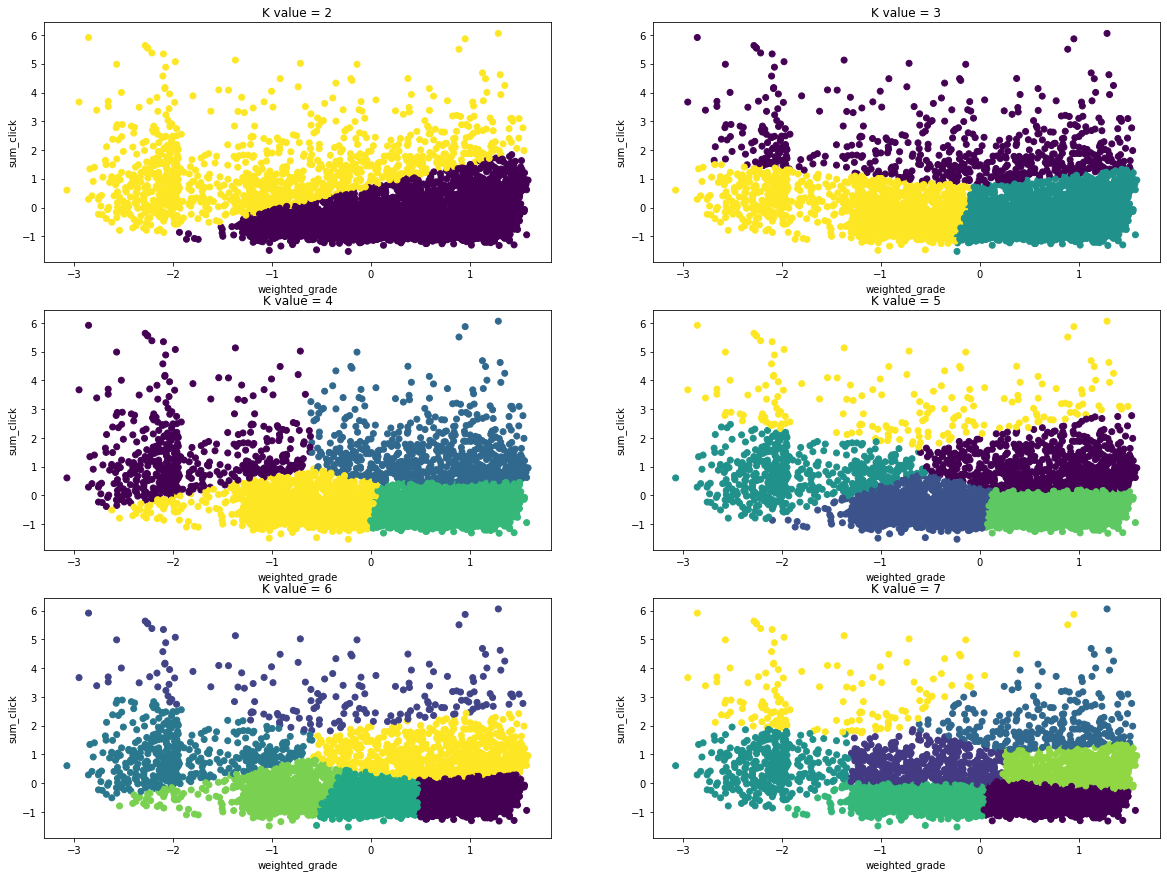

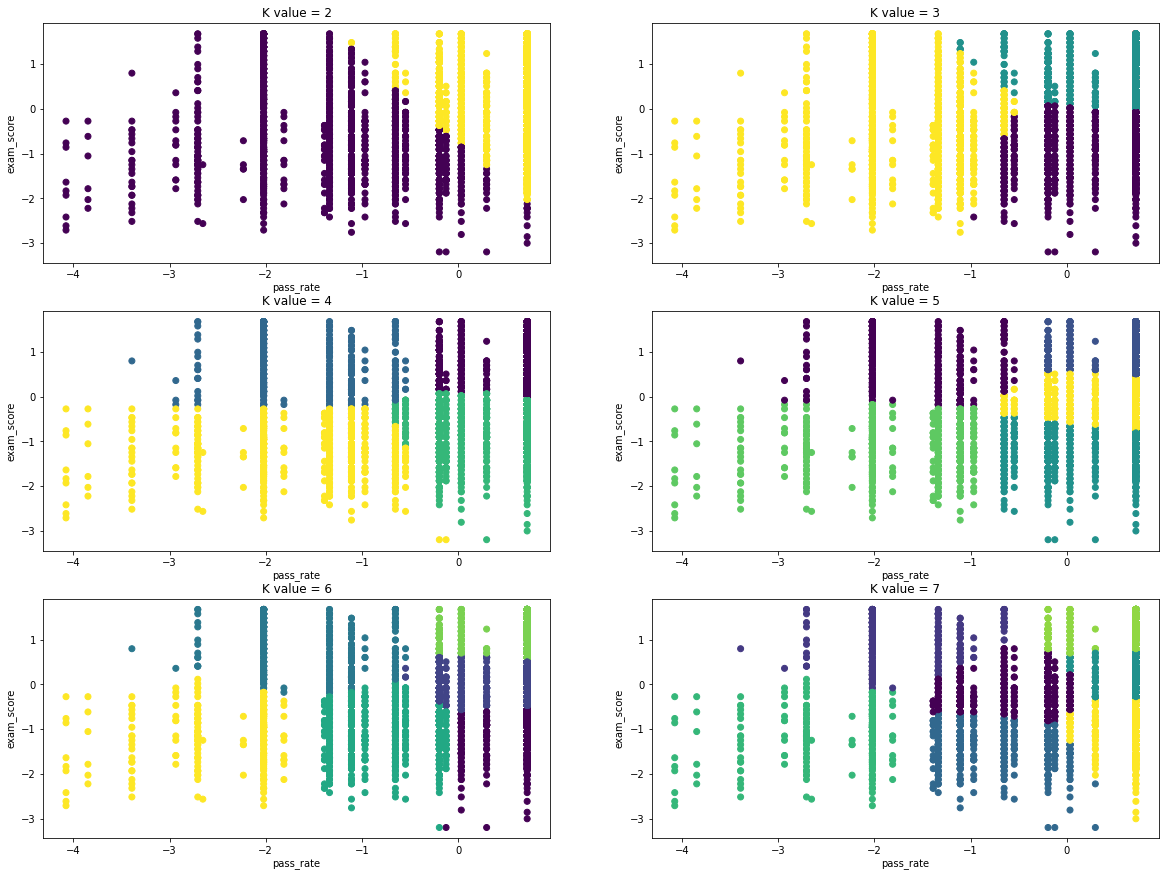

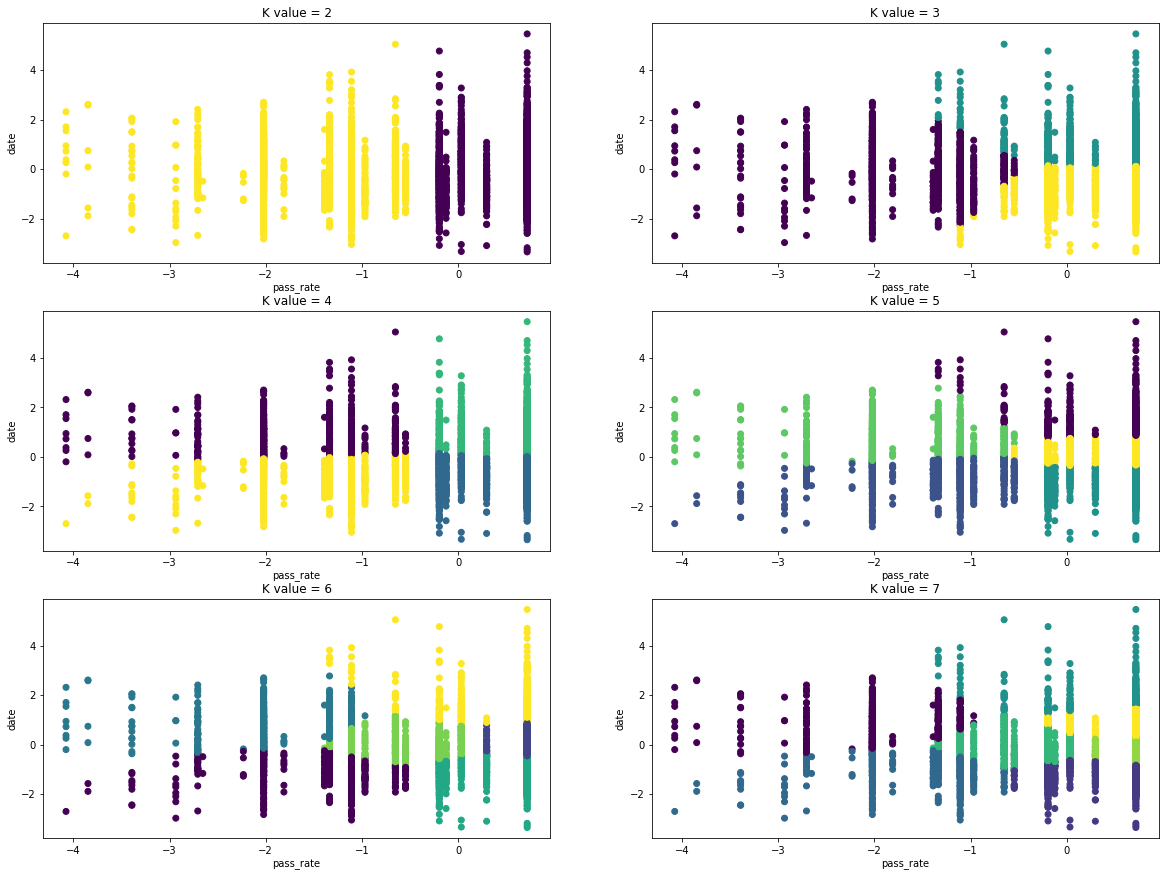

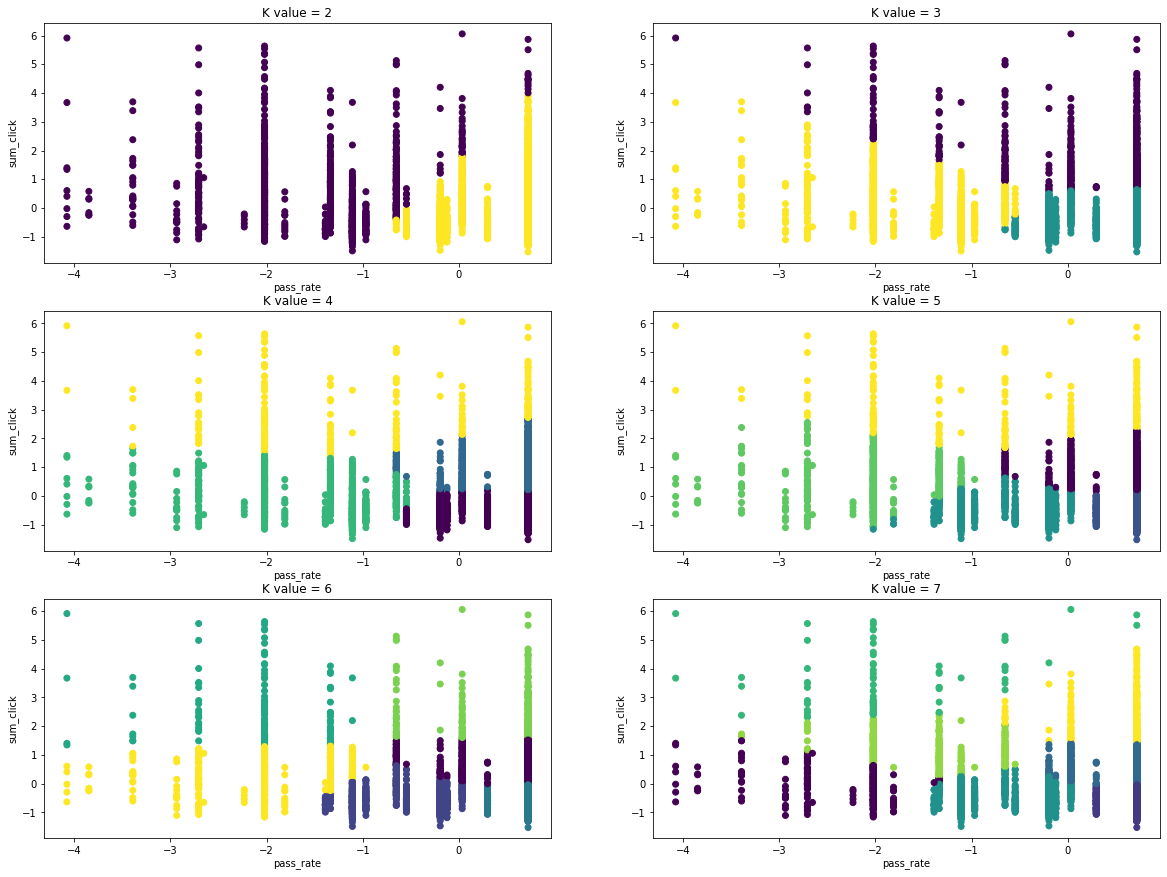

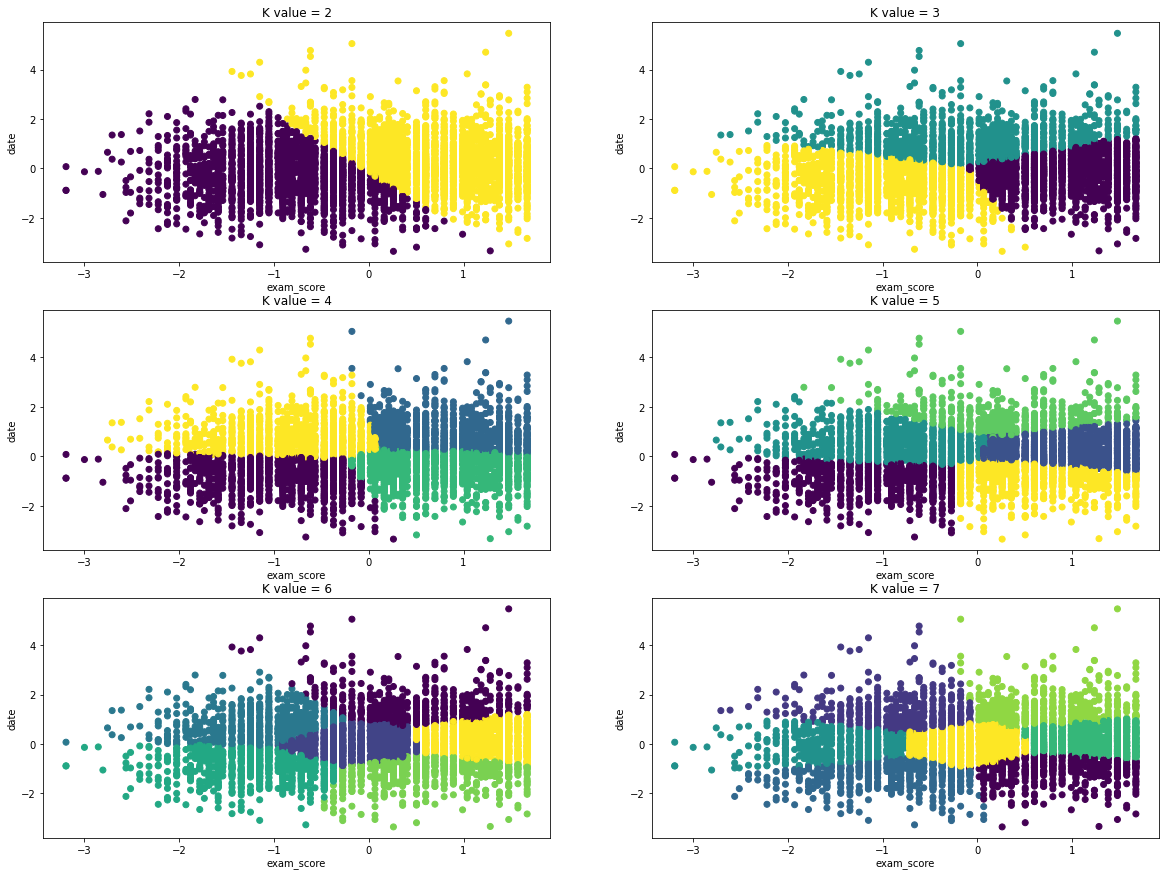

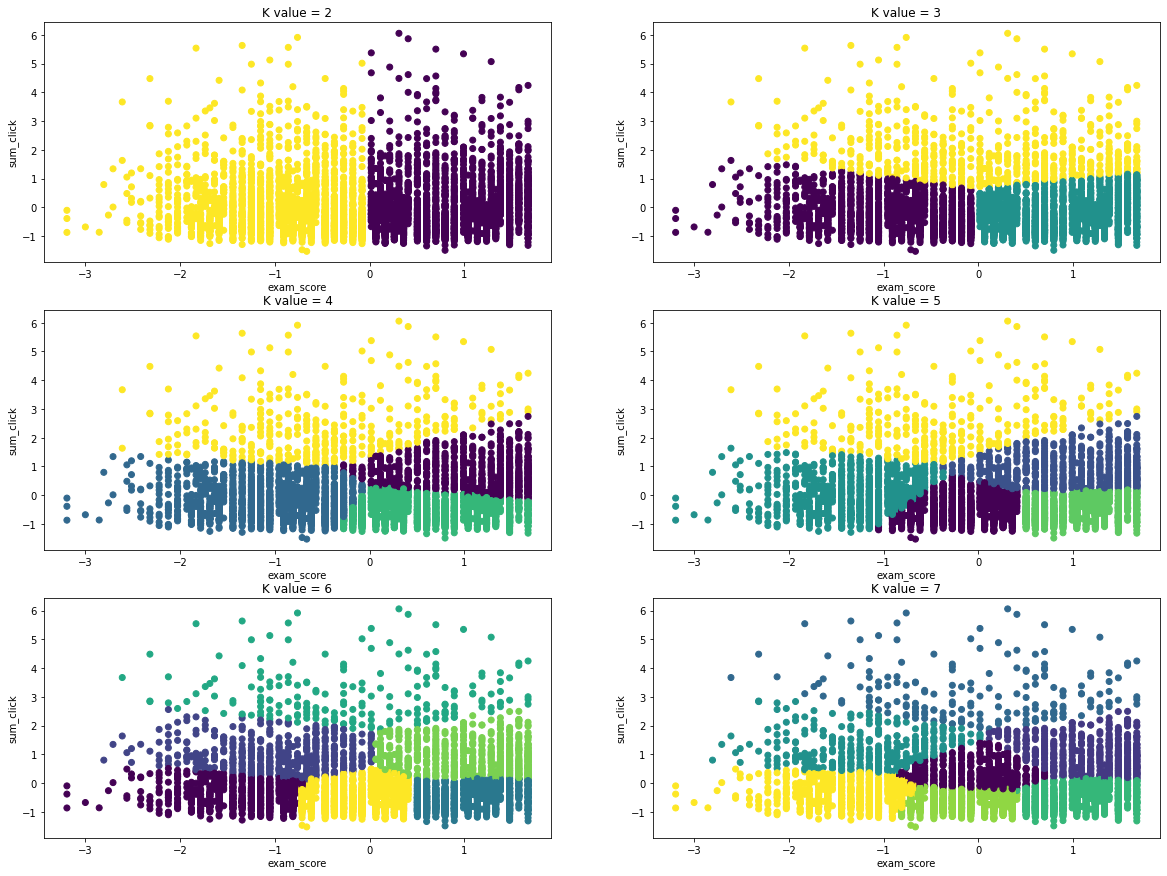

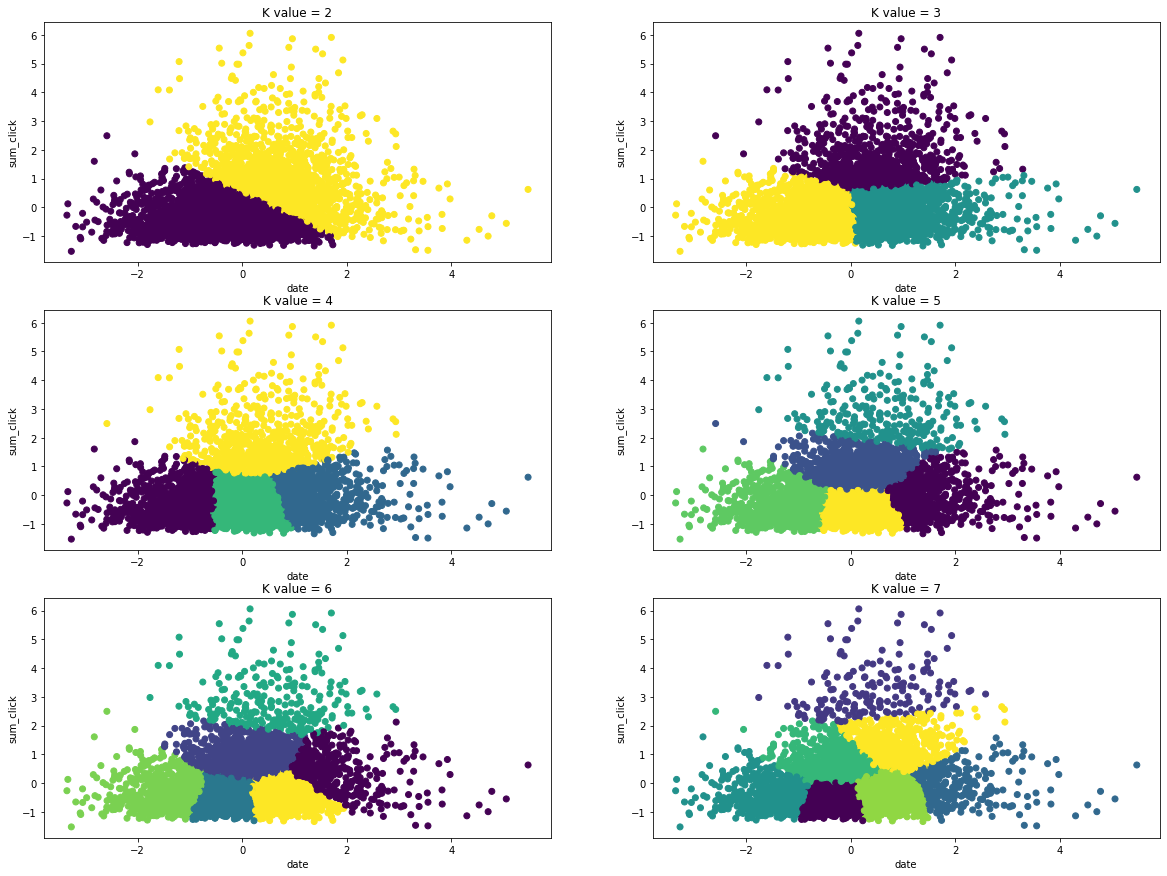

In [110]:
from sklearn.cluster import KMeans

#컬럼명 list에 저장
colname=df_features_cluster.columns.values

# i,k feature 2개 선택을 위한 loop
for i in range(0, 6):
    for k in range(i+1,7):
        # figure size설정
        plt.figure(figsize=(20,15))
        selectedDf=ssDf.iloc[:,[i,k]]
        
        # j 클러스터 개수 선택
        for j in range(2,8):
            # 클러스터 생성
            kmeans = KMeans(n_clusters = j)
            result_cluster = kmeans.fit_predict(selectedDf)
            
            # 2행 3열을 가진 서브플롯 추가 (인덱스 = j)
            plt.subplot(3, 2, j-1)
            # 서브플롯의 라벨링
            plt.title("K value = {}".format(j))
            plt.xlabel(colname[i])
            plt.ylabel(colname[k])
            # 클러스터링 그리기
            plt.scatter(selectedDf.iloc[:,0], selectedDf.iloc[:,1], c=result_cluster)  
            #클러스터링 결과(어떤 클러스터에 배치됐는지)를 cluster변수에 저장
            cluster=kmeans.labels_

            # clustering 점수 평가
            #print("Silhouette Score of k=",j," : ",silhouette_score(ssDf[['weighted_grade', 'exam_score']],cluster))
        plt.show()






In [111]:
## component 2개로 PCA 진행
### (feature 2개로 clustering해서 scatter plot해보기 위해)


In [112]:
#PCA 
from sklearn.decomposition import PCA

pca=PCA(n_components=2)
principalComponents=pca.fit_transform(mmDf.values)
principalDF=pd.DataFrame(data=principalComponents,columns=['principal component1','principal component2'])
print(principalDF)

      principal component1  principal component2
0    -0.343692             -0.143745            
1    -0.260187             -0.149159            
2     0.028032              0.311875            
3    -0.124657             -0.083409            
4    -0.372110             -0.181325            
...        ...                   ...            
4921 -0.256040             -0.168592            
4922 -0.199779             -0.139633            
4923 -0.216916             -0.121962            
4924 -0.090399             -0.030051            
4925 -0.154317             -0.060375            

[4926 rows x 2 columns]


In [113]:
## PCA된 dataframe으로 clustering

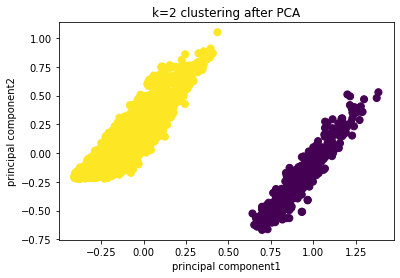

Silhouette Score 0.7201333093054775
1    4261
0    665 
Name: cluster, dtype: int64
       final_result   exam_score    pass_rate  weighted_grade      cluster
count  4926.000000   4926.000000  4926.000000  4926.000000     4926.000000
mean   0.865002      65.646569    0.868935     66.314922       0.865002   
std    0.341756      20.554425    0.182526     21.215830       0.341756   
min    0.000000      0.000000     0.125000     1.120000        0.000000   
25%    1.000000      51.000000    0.769231     51.595000       1.000000   
50%    1.000000      67.000000    1.000000     69.800000       1.000000   
75%    1.000000      82.000000    1.000000     83.677500       1.000000   
max    1.000000      100.000000   1.000000     100.000000      1.000000   


In [114]:
from sklearn.metrics.cluster import silhouette_score


kmeans=KMeans(n_clusters=2).fit(principalDF)
# clustering 결과 시각화
plt.scatter(principalDF['principal component1'],principalDF['principal component2'],c=kmeans.labels_.astype(float),s=50)
plt.xlabel('principal component1')
plt.ylabel('principal component2')
plt.title('k=2 clustering after PCA')
plt.show()

#클러스터링 결과(어떤 클러스터에 배치됐는지)를 cluster변수에 저장
cluster=kmeans.labels_

# clustering 점수 평가
print("Silhouette Score",silhouette_score(principalDF,cluster))

#final Df에 clustering 결과 컬럼 추가
df_pca_cluster=final_df.copy()
df_pca_cluster['cluster']=cluster

# 클러스터 그룹별 데이터 개수 확인
print(df_pca_cluster['cluster'].value_counts())

print(df_pca_cluster.describe())



In [115]:
# 클러스터 별로 데이터 추출
con1=df_pca_cluster['cluster'] == 0
con2=df_pca_cluster['cluster']==1
df1 = df_pca_cluster.loc[con1, :]
df2 = df_pca_cluster.loc[con2, :]

# cluster 0의 통계정보 확인
print(df1.describe())

       final_result  exam_score   pass_rate  weighted_grade  cluster
count  665.0         665.000000  665.000000  665.000000      665.0  
mean   0.0           34.162406   0.749947    49.604218       0.0    
std    0.0           9.688558    0.209879    15.485615       0.0    
min    0.0           0.000000    0.125000    1.120000        0.0    
25%    0.0           28.000000   0.625000    41.730000       0.0    
50%    0.0           34.000000   0.769231    49.200000       0.0    
75%    0.0           40.000000   0.923077    59.300000       0.0    
max    0.0           64.000000   1.000000    93.060000       0.0    


In [116]:
# cluster 1의 통계정보 확인
print(df2.describe())

       final_result   exam_score    pass_rate  weighted_grade  cluster
count  4261.0        4261.000000  4261.000000  4261.000000     4261.0 
mean   1.0           70.560197    0.887505     68.922905       1.0    
std    0.0           17.173157    0.170574     20.799104       0.0    
min    1.0           24.000000    0.125000     5.740000        1.0    
25%    1.0           58.000000    0.833333     56.600000       1.0    
50%    1.0           71.000000    1.000000     73.480000       1.0    
75%    1.0           84.000000    1.000000     85.475000       1.0    
max    1.0           100.000000   1.000000     100.000000      1.0    


         final_result  exam_score  pass_rate  weighted_grade
cluster                                                     
0        0.0           34.162406   0.749947   49.604218     
1        1.0           70.560197   0.887505   68.922905     


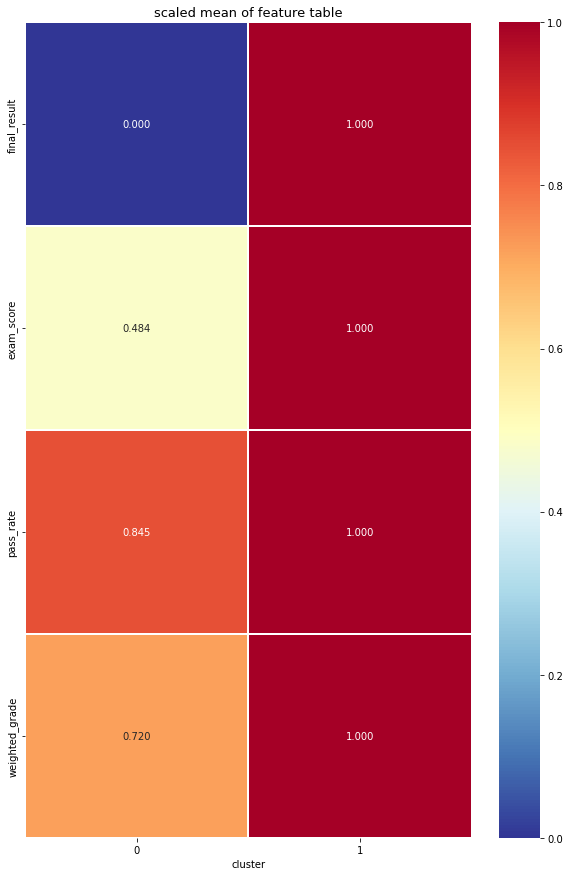

In [117]:
# cluster별 각 컬럼의 평균
temp=df_pca_cluster.groupby(['cluster']).mean()
print(temp)
# 보기 편하게 x,y축 바꿈
cluster_mean=temp.transpose()

# 클러스터별 feature평균 비교 좀 더 눈에 잘띄게 
# 해당 feature평균 가장 큰 클러스터의 값을 1로 바뀜
mean_table=cluster_mean.div(cluster_mean.max(axis=1),axis=0)

#히트맵 그리기
plt.figure(figsize=(10,15))
sns.heatmap(mean_table,
           annot=True,
           fmt='.3f',
           linewidths=0.1,
           cmap='RdYlBu_r')
plt.title('scaled mean of feature table',fontsize=13)
plt.show()

In [118]:
## 위 결과 보면 두 클러스터가 final result 1,0으로 클러스터가 나뉜것 같음 (pass 했냐 fail했냐)

In [119]:
## 이번에는 전체 feature를 사용해서 clustering 진행

클러스터 개수: 2 응집도 : 5120668.7747079125
Silhouette Score 0.29632092673029864
클러스터 개수: 3 응집도 : 3829950.5510130576
Silhouette Score 0.30226797543407635
클러스터 개수: 4 응집도 : 3248810.9520917353
Silhouette Score 0.27262489203761797
클러스터 개수: 5 응집도 : 2801475.026453804
Silhouette Score 0.2717608758976636
클러스터 개수: 6 응집도 : 2472807.410461627
Silhouette Score 0.26312276100618837
클러스터 개수: 7 응집도 : 2213612.722220139
Silhouette Score 0.2671555387737171
클러스터 개수: 8 응집도 : 2040930.4417394577
Silhouette Score 0.2563853759320857
클러스터 개수: 9 응집도 : 1899927.8570924231
Silhouette Score 0.2524569032533645
클러스터 개수: 10 응집도 : 1784515.8523090605
Silhouette Score 0.24857826165479502
클러스터 개수: 11 응집도 : 1688256.5134398902
Silhouette Score 0.24465001634581385
클러스터 개수: 12 응집도 : 1592665.977390598
Silhouette Score 0.25031132051262733
클러스터 개수: 13 응집도 : 1500789.7300176786
Silhouette Score 0.2477006470262449
클러스터 개수: 14 응집도 : 1418662.2604106702
Silhouette Score 0.2518259478923766
클러스터 개수: 15 응집도 : 1344914.7482631963
Silhouette Score 0.

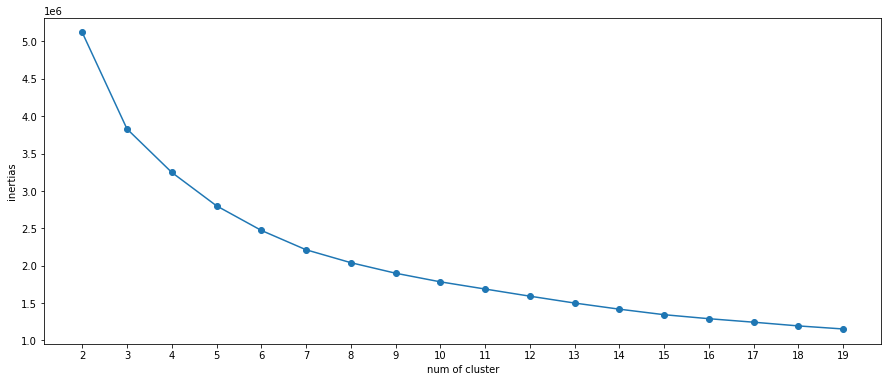

In [120]:
df_features_cluster=df.copy()
df_features_cluster=df.drop("id_student", axis=1)

# 최적의 clustering개수 찾기 위해 응집도 수치 확인

# 응집도 결과 저장을 위한 리스트
inertias=[]
ks=range(2,20)
for k in ks:
    kmeans=KMeans(n_clusters=k).fit(df_features_cluster)
    #응집도 결과 리스트에 저장
    inertias.append(kmeans.inertia_)
    print('클러스터 개수: {}'.format(k), '응집도 : {}'.format(kmeans.inertia_))
    cluster=kmeans.labels_
    print("Silhouette Score",silhouette_score(df_features_cluster,cluster))
    
# 응집도 시각화
plt.figure(figsize=(15,6))
plt.plot(ks,inertias,'-o')
plt.xlabel('num of cluster')
plt.ylabel('inertias')
plt.xticks(ks)
plt.show()


In [121]:
### k=6부터 응집도 수치가 크게 변화 없으므로 적정k값은 6부근이라 판단

In [122]:
# 클러스터 개수 6으로 진행
kmeans=KMeans(n_clusters=6).fit(df_features_cluster)
#클러스터링 결과(어떤 클러스터에 배치됐는지)를 cluster변수에 저장
cluster=kmeans.labels_

# dataframe에 clustering 결과 컬럼 추가
df_features_cluster['cluster']=cluster

# 클러스터 그룹별 데이터 개수 확인
print(df_features_cluster['cluster'].value_counts())



2    1149
0    1087
5    1050
1    748 
4    462 
3    430 
Name: cluster, dtype: int64


         num_of_prev_attempts  final_result  weighted_grade  pass_rate  \
cluster                                                                  
0        0.069917              0.999080      79.630235       0.964982    
1        0.114973              0.573529      50.867019       0.757422    
2        0.055701              1.000000      85.310370       0.983676    
3        0.051163              0.932558      25.288349       0.515735    
4        0.272727              0.909091      63.432771       0.865787    
5        0.159048              0.739048      60.818252       0.869411    

         exam_score        date  sum_click  
cluster                                     
0        75.457222   81.619458   1.768567   
1        44.754011   71.955519   1.863260   
2        84.421236   111.925273  2.036085   
3        71.367442   107.348009  2.581854   
4        64.205628   145.728538  2.183326   
5        48.120000   107.390248  1.989660   


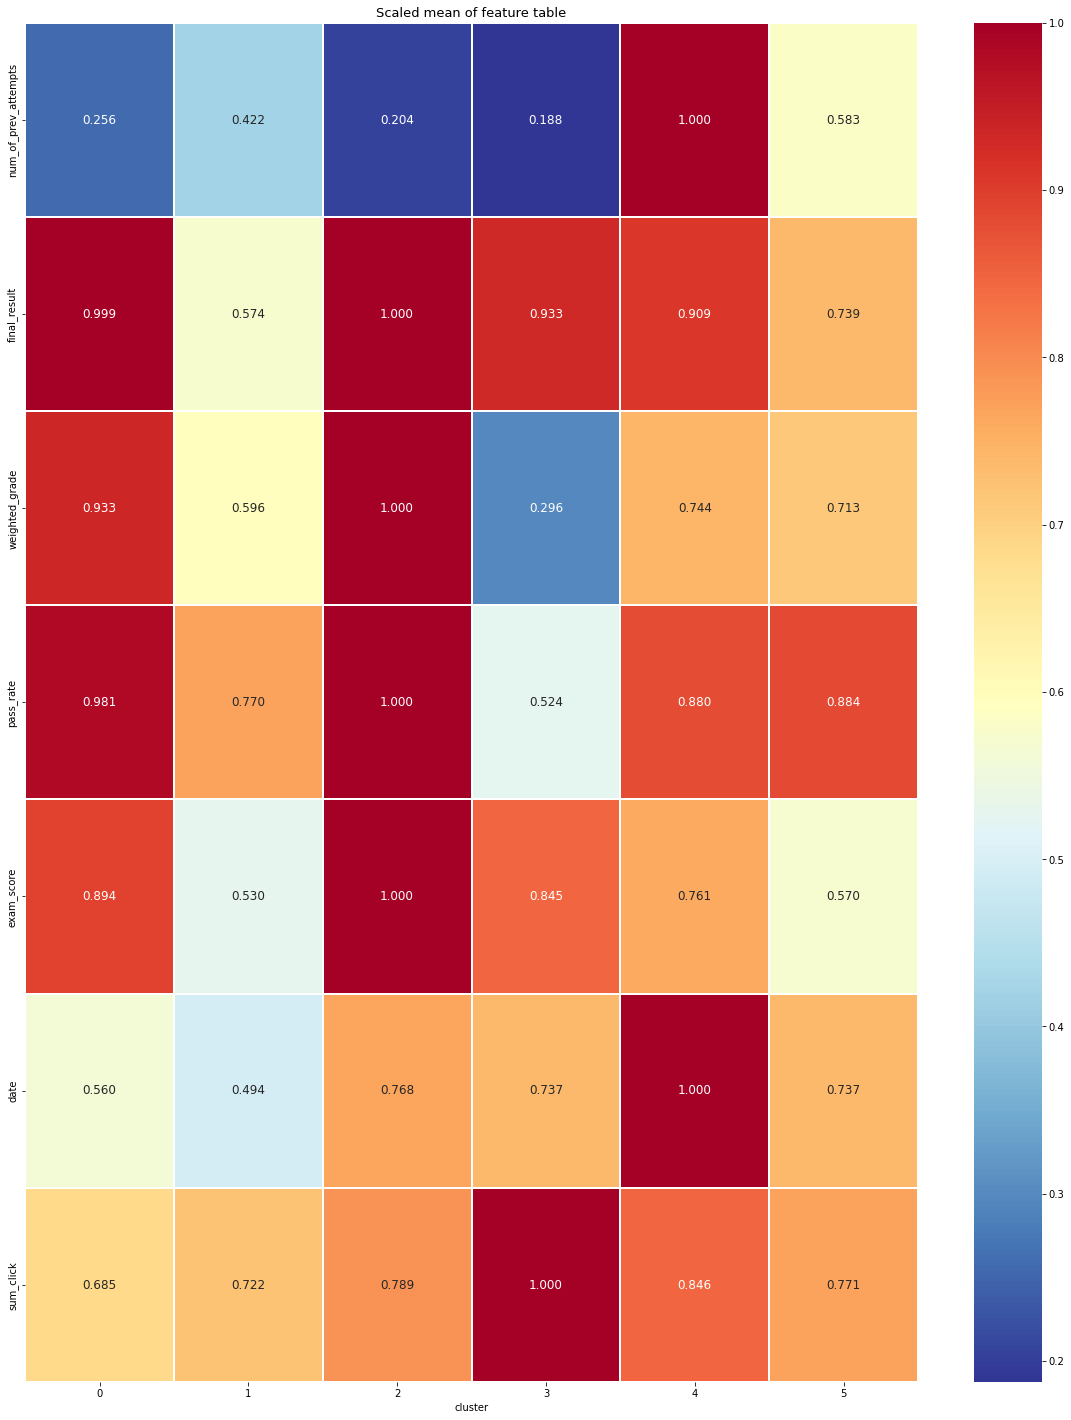

In [123]:
# cluster별 각 컬럼의 평균
temp=df_features_cluster.groupby(['cluster']).mean()
print(temp)
# 보기 편하게 x,y축 바꿈
cluster_mean=temp.transpose()

# 클러스터별 feature평균 비교 좀 더 눈에 잘띄게 
# 해당 feature평균 가장 큰 클러스터의 값을 1로 바뀜
mean_table=cluster_mean.div(cluster_mean.max(axis=1),axis=0)

#히트맵 그리기
plt.figure(figsize=(20,25))
annot_kws={'fontsize':12}
sns.heatmap(mean_table,
           annot=True,
           fmt='.3f',
           linewidths=0.1,
           annot_kws=annot_kws,
           cmap='RdYlBu_r')
plt.title('Scaled mean of feature table',fontsize=13)
plt.show()

In [124]:
## 클러스터별 feature들의 값 분포 자세히 살펴보기

<AxesSubplot:xlabel='sum_click', ylabel='cluster'>

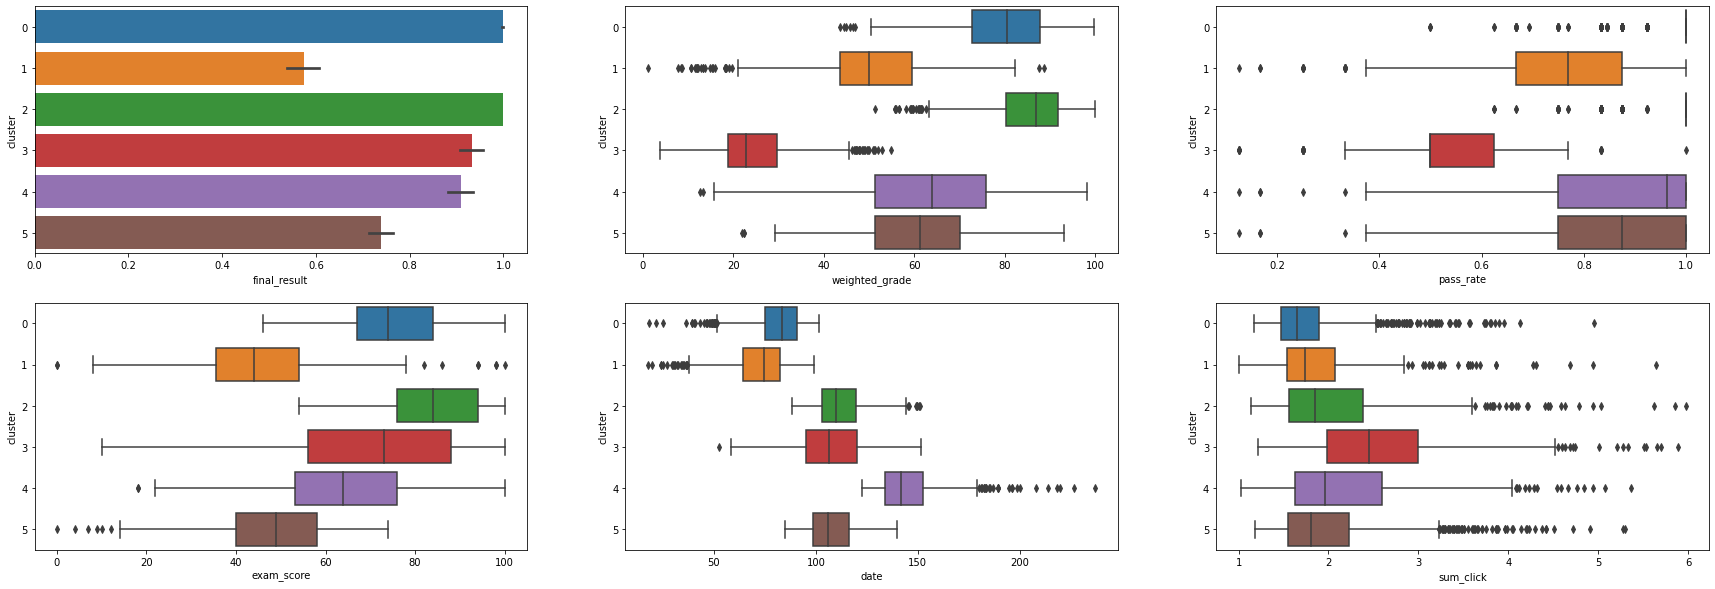

In [125]:
# 그래프 2행 3열로 배치
figure,((ax1,ax2,ax3),(ax4,ax5,ax6))=plt.subplots(nrows=2,ncols=3)
figure.set_size_inches(30,10)# 사이즈 설정


sns.barplot(data=df_features_cluster,y='cluster',x='final_result',orient='h',ax=ax1)
sns.boxplot(data=df_features_cluster,y='cluster',x='weighted_grade',orient='h',ax=ax2)
sns.boxplot(data=df_features_cluster,y='cluster',x='pass_rate',orient='h',ax=ax3)
sns.boxplot(data=df_features_cluster,y='cluster',x='exam_score',orient='h',ax=ax4)
sns.boxplot(data=df_features_cluster,y='cluster',x='date',orient='h',ax=ax5)
sns.boxplot(data=df_features_cluster,y='cluster',x='sum_click',orient='h',ax=ax6)
